# Checklist: (to remove before submission)
1. compiled all code
2. modify variable & run again
3. result evaluation + interpretation
4. members' contribution (put at the end)
5. After discussion: use python note for presentation

# WQD7003 Data Analytics - Group 13

# Project Topic: Predicting Future Poverty Population in the US

This project uses Cross-Industry Standard Process for Data Mining (CRISP-DM) methodology. The methodology consists of 6 phases:

1.   Business Understanding
2.   Data Understanding
3.   Data Preparation
4.   Modeling
5.   Evaluation
6.   Deployment

Each phase is performed and outlined in detail as follows:



# 1. Business Understanding

a. Business Objective:

*   To forecast future poverty population in the US.
*   To understand the trends and attributes contributing to poverty.
*   Support decision-making for poverty alleviation policies and social programs.

b. Assess Situation

*   Data source from US Census Bureau data
*   Limited timeframe of data for specific categories
*   Lack of data at individual levels for more granular analysis

c. Data Mining Goals

*   Identify the key identities of poverty
*   Develop a robust model to forecast the share of people earning below poverty wages
*   Achieve high accuracy of predicition (80%)



d. Project Plan


*   Completed project and submit by week 13
*   Prepare deliverables, including Python notebook and visualization









# 2. Data Understanding

  a. Collect initial data
*   Data collected: Historical Poverty Tables: People and Families - 1959 to 2023
*   Data source: United States Census Bureau
*   Data format: MS Excel File (264KB)

b. Describe data

*   Data consists of 6 tables:

|Table|Table Name|
|-----|----------|
|table2|Poverty Status of People by Family Relationship, Race, and Hispanic Origin: 1959 to 2023|
|table4|Poverty Status of Families by Type of Family, Presence of Related Children, Race, and Hispanic Origin: 1959 to 2023|
|table6|Number and Percent of People at Varying Degrees of Poverty and the Near Poor: 1959 to 2023|
|table7|Poverty of People by Sex and Age: 1966 to 2023|
|tableA2|Households by Total Money Income, Race, and Hispanic Origin of Householder: 1967 to 2023|
|tableA3|Poverty Status of People by Age, Race, and Hispanic Origin: 1959 to 2023|










# 3. Data Pre-Processing

Overview:

a. Cleaning Process made in Python:


*   Removed duplicate value - happen in year 2017 & 2013 due to change in system & new methodolody
*   Removed foot note in "Year" column
*   Merging table 2, table A2 and table 3
*   Identified missing value - labeled as "N" and "(B)"
*   Impute missing values


  |Imputation method| Reason|
  |-----------------|-------|
  |simple calculation| Missing value in "total" column, can be calculate using "number" / "percent"|
  |regression-based| time-series data, missing consecutive years (ie 16 years), happened in earliest year|
  |forward fill using earliest available data| random missing value|
  |extrapolation| missing value appear after merging tables|







## 3.1 Cleaning process in python

In [25]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from google.colab import drive
import os
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [26]:
# Mount Google Drive to the Colab environment
drive.mount('/content/drive')

# Define the path to your dataset folder within Google Drive
data_dir = '/content/drive/My Drive/WQD7003_DA_Group13/Data_Cleaning/Archive/table/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# functions:

def identify_duplicate(df,child_status=False):
    """
    function: to identify duplicate year for each race category
    input: table (dataframe) with "Year" column after remove the footnote
    output: duplicate year identify for each race category (dict)
    """
    duplicate_dict = {}
    race_list = df['Race Category'].unique()
    if child_status == False:
        for i in race_list:
            df2 = df[df['Race Category'] == i]
            duplicates_year = df2[df2['Year'].duplicated()]['Year'].unique()
            if len(duplicates_year) != 0:
                duplicate_dict[i] = duplicates_year
    else:
        status = df['Child Status'].unique()
        for i in race_list:
            for x in status:
                df2 = df[(df['Race Category'] == i) & (df['Child Status'] == x) ]
                duplicates_year = df2[df2['Year'].duplicated()]['Year'].unique()
                if len(duplicates_year) != 0:
                    duplicate_dict[i] = duplicates_year
    return duplicate_dict

def missing_value(df):
    """
    funtion: print out the information of missing value such as Year, Race category and column name
    input: table (dataframe)
    output: Year, Race category and coulmn name table (dataframe)
    """
    missing_info = []
    pd.set_option('display.max_colwidth', None)
    # pd.set_option('display.max_rows', 20)
    for column in df.columns:
        if column not in ['Year', 'Race Category']:
            missing_rows = df[df[column].isna()]
            for _, row in missing_rows.iterrows():
                missing_info.append({
                    'year': row['Year'],
                    'race': row['Race Category'],
                    'column': column
                })
    missing_df = pd.DataFrame(missing_info)
    return missing_df

def plot_correlation(df, race, status=None):
    """
    function: plot the correlation matrix heatmap
    input: table without missing value, for specific race and child status (dataframe)
    output: correlation matrix heatmap, for specific race and child status
    """
    if not status:
        df_race = df[(df["Race Category"] == race)]
    else:
        df_race = df[(df["Race Category"] == race) & (df["Child Status"]==status)]
    df_complete = df_race.dropna()
    df_complete = df_complete.drop(["Race Category", "Child Status","Year_footnote"], axis=1)
    df_complete = df_complete.astype(int)
    corr_matrix = df_complete.corr(method="pearson", numeric_only=True)
    plt.figure(figsize=(5,3), dpi =150)
    sns.heatmap(corr_matrix,annot=True,annot_kws={"size": 4}, fmt=".2f", linewidth=.3)
    plt.show()

### 3.1.1 Individual Table

#### table2

The data cleaning processes for table 2 are as follow:

1. Understand the data structure

In [28]:
table2 = pd.read_excel(os.path.join(data_dir, 'table2.xlsx'))

structure_t2 = table2.dtypes
shape_t2 = table2.shape
print(structure_t2, shape_t2)

Year                                                                                             object
Race Category                                                                                    object
All people_Total                                                                                  int64
All people_Below poverty_Number                                                                   int64
All people_Below poverty_Percent                                                                float64
People in families_All families_Total                                                            object
People in families_All families_Below poverty_Number                                              int64
People in families_All families_Below poverty_Percent                                           float64
People in families_Families with female householder, no spouse present_Total                     object
People in families_Families with female householder, no spouse p

2. Change the column "Year" to "Year_footnote", and create a new column "Year"
    
    The Year_footnote will stored both the year and footnote information, while the "Year" will only stored year data without footnote

In [29]:
table2 = table2.rename(columns={'Year': 'Year_footnote'})
table2["Year"] = table2["Year_footnote"].astype(str).str.extract(r'(\d{4})')

3. Identify missing value

    Missing value was labeled as "N" and "(B)" in the raw data
    
    We first replaced the character "N" and "(B)" to NaN, then we fill in the missing value using appropriate imputation method

In [30]:
table2.replace("N", pd.NA, inplace=True)
table2.replace("(B)", pd.NA, inplace=True)
print("Total missing value in each column:")
table2.isna().sum()

Total missing value in each column:


,0
Year_footnote,0
Race Category,0
All people_Total,0
All people_Below poverty_Number,0
All people_Below poverty_Percent,0
People in families_All families_Total,4
People in families_All families_Below poverty_Number,0
People in families_All families_Below poverty_Percent,0
"People in families_Families with female householder, no spouse present_Total",16
"People in families_Families with female householder, no spouse present_Below poverty_Number",0


In [31]:
table2['missing_value'] = table2.isnull().any(axis=1).map({True: 'Yes', False: 'No'})

In [32]:
missing_value_t2 = missing_value(table2)
missing_value_t2

,year,race,column
0,1968,Black,People in families_All families_Total
1,1967,Black,People in families_All families_Total
2,1966,Black,People in families_All families_Total
3,1959,Black,People in families_All families_Total
4,1964,All Races,"People in families_Families with female householder, no spouse present_Total"
5,1963,All Races,"People in families_Families with female householder, no spouse present_Total"
6,1962,All Races,"People in families_Families with female householder, no spouse present_Total"
7,1961,All Races,"People in families_Families with female householder, no spouse present_Total"
8,1960,All Races,"People in families_Families with female householder, no spouse present_Total"
9,1959,All Races,"People in families_Families with female householder, no spouse present_Total"


4. Impute missing value

  Noticed that the missing value appear in "Total" column, hence we can calculate the missing value by using the "Number" and "Percent" column

  Total = Number / (Percent / 100)

  For example:

  'People in families_All families_Total' = 'People in families_All families_Below poverty_Number' / ('People in families_All families_Below poverty_Percent' / 100)

In [33]:
mask = table2['People in families_All families_Total'].isna()
table2.loc[mask, 'People in families_All families_Total'] = round(table2.loc[mask, 'People in families_All families_Below poverty_Number'] / (table2.loc[mask, 'People in families_All families_Below poverty_Percent'] /100),0)
mask = table2['People in families_Families with female householder, no spouse present_Total'].isna()
table2.loc[mask, 'People in families_Families with female householder, no spouse present_Total'] = round(table2.loc[mask, 'People in families_Families with female householder, no spouse present_Below poverty_Number'] / (table2.loc[mask, 'People in families_Families with female householder, no spouse present_Below poverty_Percent'] /100),0)
mask = table2['Unrelated individuals_Total'].isna()
table2.loc[mask, 'Unrelated individuals_Total'] = round(table2.loc[mask, 'Unrelated individuals_Below poverty_Number'] / (table2.loc[mask, 'Unrelated individuals_Below poverty_Percent'] /100),0)

In [34]:
# Re-check missing value

table2.isna().sum()

,0
Year_footnote,0
Race Category,0
All people_Total,0
All people_Below poverty_Number,0
All people_Below poverty_Percent,0
People in families_All families_Total,0
People in families_All families_Below poverty_Number,0
People in families_All families_Below poverty_Percent,0
"People in families_Families with female householder, no spouse present_Total",0
"People in families_Families with female householder, no spouse present_Below poverty_Number",0


5. Duplicate values

  The duplicate values happended in year 2017 and 2013.

  The reason of duplicate values are mainly due to
  1. For year 2017, the duplicate is due to an updated processing system
  2. For year 2013, the duplicate is due to redesigned questions.

  Our solution is to remove the old record and keep the updated records as it is more suitable for comparison with subsequent years, since it reflected the new system / methodology.

In [35]:
# identify duplicate values: 22 duplicate years to be removed

duplicate_t2 = identify_duplicate(table2)
duplicate_t2

{'All Races': array(['2017', '2013'], dtype=object),
 'White Alone': array(['2017', '2013'], dtype=object),
 'White Alone, Not Hispanic': array(['2017', '2013'], dtype=object),
 'Black Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Black Alone': array(['2017', '2013'], dtype=object),
 'Asian Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Asian Alone': array(['2017', '2013'], dtype=object),
 'American Indian and Alaska Native Alone or in Combination': array(['2017', '2013'], dtype=object),
 'American Indian and Alaska Native Alone': array(['2017', '2013'], dtype=object),
 'Two or More Races': array(['2017', '2013'], dtype=object),
 'Hispanic (any race)': array(['2017', '2013'], dtype=object)}

In [36]:
# remove duplicate values:
# remove year 2017 without footnote (3) or year 2013 with footnote (5)

table2['Year_footnote'] = table2['Year_footnote'].astype(str)
table2 = table2[(table2['Year_footnote'] != '2017') & (table2['Year_footnote'] != '2013 (5)')]
table2 = table2.drop(columns=['Year_footnote'])

In [37]:
# re-check duplicate values:

duplicate_t2 = identify_duplicate(table2)
duplicate_t2

{}

#### table4

1. Understanding data structure

In [38]:
table4 = pd.read_excel(os.path.join(data_dir, 'table4.xlsx'))

In [39]:
structure_t4 = table4.dtypes
shape_t4 = table4.shape
print(structure_t4, shape_t4)

Year                                                                            object
Race Category                                                                   object
Child Status                                                                    object
All families_Total                                                              object
All families_Below poverty_Number                                                int64
All families_Below poverty_Percent                                             float64
Married-couple families_Total                                                   object
Married-couple families_Below poverty_Number                                    object
Married-couple families_Below poverty_Percent                                   object
Families with a male householder, no spouse present_Total                       object
Families with a male householder, no spouse present_Below poverty_Number        object
Families with a male householder, no spouse

2. Change the column "Year" to "Year_footnote", and create a new column "Year"
    
    The Year_footnote will stored both the year and footnote information, while the "Year" will only stored year data without footnote

In [40]:
table4 = table4.rename(columns={'Year': 'Year_footnote'})
table4["Year"] = table4["Year_footnote"].astype(str).str.extract(r'(\d{4})')

3. Identify missing value

    Missing value was labeled as "N" and "(B)" in the raw data
    
    We first replaced the character "N" and "(B)" to NaN, then we fill in the missing value using appropriate imputation method

In [41]:
table4.replace("N", pd.NA, inplace=True)
table4.replace("(B)", pd.NA, inplace=True)
print("Total missing value in each column:")
table4.isna().sum()

Total missing value in each column:


,0
Year_footnote,0
Race Category,0
Child Status,0
All families_Total,6
All families_Below poverty_Number,0
All families_Below poverty_Percent,0
Married-couple families_Total,39
Married-couple families_Below poverty_Number,89
Married-couple families_Below poverty_Percent,89
"Families with a male householder, no spouse present_Total",40


In [42]:
table4['missing_value'] = table4.isnull().any(axis=1).map({True: 'Yes', False: 'No'})

missing_value_t4 = missing_value(table4)
missing_value_t4

,year,race,column
0,1966,White,All families_Total
1,1965,White,All families_Total
2,1964,White,All families_Total
3,1962,White,All families_Total
4,1961,White,All families_Total
...,...,...,...
569,1976,Hispanic (any race),"Families with a female householder, no spouse present_Below poverty_Percent"
570,1975,Hispanic (any race),"Families with a female householder, no spouse present_Below poverty_Percent"
571,1974,Hispanic (any race),"Families with a female householder, no spouse present_Below poverty_Percent"
572,1973,Hispanic (any race),"Families with a female householder, no spouse present_Below poverty_Percent"


4. Impute missing value

    a. for "All families_Total" column, since only total value missing, hence we can recalculate back the missing value using : Number/ Percent

    b. missing values in

|No|Year|Race Category|Child Status|Column|Imputation method|
|--|----|--------------|------------|------|----------------|
|a|1960-1966|White|With Children Under 18 Years|All families_Total|Calculate the missing column since we have number and percent figure|
|b|1959-1972|All Races|With and Without Children Under 18 Years|Married-couple families_Below poverty_Number,Married-couple families_Below poverty_Percent, Families with a male householder, no spouse present_Below poverty_Number,Families with a male householder, no spouse present_Below poverty_Percent | regression-based method
|c|1959-1972|All Races|With Children Under 18 Years|Married-couple families_Below poverty_Number,Married-couple families_Below poverty_Percent, Families with a male householder, no spouse present_Below poverty_Number,Families with a male householder, no spouse present_Below poverty_Percent | regression-based method
|d|1959-1973|White|With and Without Children Under 18 Years|Married-couple families_Below poverty_Number,Married-couple families_Below poverty_Percent, Families with a male householder, no spouse present_Below poverty_Number,Families with a male householder, no spouse present_Below poverty_Percent | regression-based method
|e|1959-1973|White|With Children Under 18 Years| all columns except "All people" columns| regression-based method
|f|1967-1973|Black|With and Without Children Under 18 Years|Married-couple families_Below poverty_Number,Married-couple families_Below poverty_Percent, Families with a male householder, no spouse present_Below poverty_Number,Families with a male householder, no spouse present_Below poverty_Percent | regression-based method
|g|1967-1973|Black|With Children Under 18 Years|all columns except "All people" colum| regression-based method
|h|1972-1986|Hispanic (any race)|With Children Under 18 Years|all columns except "All people" colum| impute using an estimated ratio (based on earliest available data), regression-based method is not suitable due to weak correlation and negative R^2|
|i|1972|Hispanic (any race)|With and Without Children Under 18 Years|all columns except "All people" colum| impute using an estimated ratio (based on earliest available data), regression-based method is not suitable due to weak correlation and negative R^2|
|j|Varioys|Asian alone, American Indian and Alaska Native Alone or in Combination, American Indian and Alaska Alone, Two ore more race|All child status|Families with a male householder, no spouse present_Below poverty_Number,Families with a male householder, no spouse present_Below poverty_Percent | calculate the missing value by using the data from "All people" column - "Married couple families" - "Families with female household" |

In [43]:
# a. impute missing value by "total" = "number"/"percent"
mask = table4['All families_Total'].isna()
table4.loc[mask, 'All families_Total'] = round(table4.loc[mask, 'All families_Below poverty_Number'] / (table4.loc[mask, 'All families_Below poverty_Percent'] /100),0)

In [44]:
# b. impute missing value by regression-based imputation method
# missing value in Race category: All races, child status: With and Without Children Under 18 Years

t4_allrace = table4[(table4["Race Category"] == "All Races") & (table4["Child Status"]=="With and Without Children Under 18 Years")]
t4_allrace_complete = t4_allrace.dropna()
t4_allrace_missing = t4_allrace[t4_allrace["Married-couple families_Below poverty_Percent"].isna()]


In [45]:
X_train_ar1 = t4_allrace_complete[['All families_Below poverty_Number','All families_Below poverty_Percent','All families_Total']]

y_train_ar1 = t4_allrace_complete['Families with a male householder, no spouse present_Below poverty_Percent']

model = LinearRegression()
scores = cross_val_score(model, X_train_ar1, y_train_ar1, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_ar1, y_train_ar1)
X_missing = t4_allrace_missing[['All families_Below poverty_Number','All families_Below poverty_Percent','All families_Total']]
t4_allrace_missing['Families with a male householder, no spouse present_Below poverty_Percent'] = model.predict(X_missing).round(1)

Average R2 score: 0.5623672841130005


In [46]:
mask = t4_allrace_missing['Families with a male householder, no spouse present_Below poverty_Number'].isna()
t4_allrace_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] = (t4_allrace_missing.loc[mask, 'Families with a male householder, no spouse present_Total'] *
                                                                                                            (t4_allrace_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Percent'] /100)).round(0).astype(int)

mask = t4_allrace_missing['Married-couple families_Below poverty_Number'].isna()
t4_allrace_missing.loc[mask, 'Married-couple families_Below poverty_Number'] = (t4_allrace_missing.loc[mask, 'All families_Below poverty_Number']
                                                                                -t4_allrace_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number']
                                                                                -t4_allrace_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number']).round(0).astype(int)

mask = t4_allrace_missing['Married-couple families_Below poverty_Percent'].isna()
t4_allrace_missing.loc[mask, 'Married-couple families_Below poverty_Percent'] = ((t4_allrace_missing.loc[mask, 'Married-couple families_Below poverty_Number'] /
                                                                                     t4_allrace_missing.loc[mask, 'Married-couple families_Total']) *100).round(1)


In [47]:
# c. impute missing value by regression-based imputation method
# missing value in Race category: All races, child status: With Children Under 18 Years

t4_allrace_ch = table4[(table4["Race Category"] == "All Races") & (table4["Child Status"]=="With Children Under 18 Years")]
t4_allrace_ch_complete = t4_allrace_ch.dropna()
t4_allrace_ch_missing = t4_allrace_ch[t4_allrace_ch["Married-couple families_Below poverty_Percent"].isna()]

In [48]:
X_train_ar2 = t4_allrace_ch_complete[['All families_Below poverty_Number','All families_Below poverty_Percent']]

y_train_ar2 = t4_allrace_ch_complete['Families with a male householder, no spouse present_Below poverty_Percent']

model = LinearRegression()
scores = cross_val_score(model, X_train_ar2, y_train_ar2, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_ar2, y_train_ar2)
X_missing = t4_allrace_ch_missing[['All families_Below poverty_Number','All families_Below poverty_Percent']]
t4_allrace_ch_missing['Families with a male householder, no spouse present_Below poverty_Percent'] = model.predict(X_missing).round(1)

Average R2 score: 0.6720339553560353


In [49]:
mask = t4_allrace_ch_missing['Families with a male householder, no spouse present_Below poverty_Number'].isna()
t4_allrace_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] = (t4_allrace_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Total'] *
                                                                                                            (t4_allrace_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Percent'] /100)).round(0).astype(int)

mask = t4_allrace_ch_missing['Married-couple families_Below poverty_Number'].isna()
t4_allrace_ch_missing.loc[mask, 'Married-couple families_Below poverty_Number'] = (t4_allrace_ch_missing.loc[mask, 'All families_Below poverty_Number']
                                                                                -t4_allrace_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number']
                                                                                -t4_allrace_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number']).round(0).astype(int)

mask = t4_allrace_ch_missing['Married-couple families_Below poverty_Percent'].isna()
t4_allrace_ch_missing.loc[mask, 'Married-couple families_Below poverty_Percent'] = ((t4_allrace_ch_missing.loc[mask, 'Married-couple families_Below poverty_Number'] /
                                                                                     t4_allrace_ch_missing.loc[mask, 'Married-couple families_Total']) *100).round(1)

In [50]:
# d. impute missing value by regression-based imputation method
# # missing value in Race category: White, child status: With and Without Children Under 18 Years

t4_white = table4[(table4["Race Category"] == "White") & (table4["Child Status"]=="With and Without Children Under 18 Years")]
t4_white_complete = t4_white.dropna()
t4_white_missing = t4_white[t4_white["Families with a male householder, no spouse present_Below poverty_Number"].isna()]

In [51]:
X_train_w1 = t4_white_complete[['All families_Below poverty_Number','All families_Below poverty_Percent','Families with a female householder, no spouse present_Below poverty_Percent']]

y_train_w1 = t4_white_complete['Married-couple families_Below poverty_Percent']

model = LinearRegression()
scores = cross_val_score(model, X_train_w1, y_train_w1, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_w1, y_train_w1)
X_missing = t4_white_missing[['All families_Below poverty_Number','All families_Below poverty_Percent','Families with a female householder, no spouse present_Below poverty_Percent']]
t4_white_missing['Married-couple families_Below poverty_Percent'] = model.predict(X_missing).round(1)

Average R2 score: 0.7632533918517275


In [52]:
mask = t4_white_missing['Married-couple families_Below poverty_Number'].isna()
t4_white_missing.loc[mask, 'Married-couple families_Below poverty_Number'] = (t4_white_missing.loc[mask, 'Married-couple families_Total'] *
                                                                            (t4_white_missing.loc[mask, 'Married-couple families_Below poverty_Percent'] /100)).round(0).astype(int)

mask = t4_white_missing['Families with a male householder, no spouse present_Total'].isna()
t4_white_missing.loc[mask, 'Families with a male householder, no spouse present_Total'] = (t4_white_missing.loc[mask, 'All families_Total']
                                                                                         -t4_white_missing.loc[mask, 'Married-couple families_Total']
                                                                                         -t4_white_missing.loc[mask, 'Families with a female householder, no spouse present_Total']).round(0).astype(int)


mask = t4_white_missing['Families with a male householder, no spouse present_Below poverty_Number'].isna()
t4_white_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] = (t4_white_missing.loc[mask, 'All families_Below poverty_Number']
                                                                                                         -t4_white_missing.loc[mask, 'Married-couple families_Below poverty_Number']
                                                                                                        -t4_white_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number']).round(0).astype(int)

mask = t4_white_missing['Families with a male householder, no spouse present_Below poverty_Percent'].isna()
t4_white_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Percent'] = ((t4_white_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] /
                                                                                                             t4_white_missing.loc[mask, 'Families with a male householder, no spouse present_Total']) *100).round(1)

In [53]:
# e. impute missing value by regression-based imputation method
# missing value in Race category: White, child status: With Children Under 18 Years

t4_white_ch = table4[(table4["Race Category"] == "White") & (table4["Child Status"]=="With Children Under 18 Years")]
t4_white_ch_complete = t4_white_ch.dropna()
t4_white_ch_missing = t4_white_ch[t4_white_ch["Married-couple families_Below poverty_Percent"].isna()]

In [54]:
# random missing value in race category: White, child status :With Children Under 18 Years, column: "Families with a female householder, no spouse present_Below poverty_Number" - use forward fill

t4_white_ch_missing["Families with a female householder, no spouse present_Below poverty_Number"].fillna(method="ffill", inplace=True)
t4_white_ch_missing["Families with a female householder, no spouse present_Below poverty_Percent"].fillna(method="ffill", inplace=True)

mask = t4_white_ch_missing['Families with a female householder, no spouse present_Total'].isna()
t4_white_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Total'] = (t4_white_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number']/
                                                                            (t4_white_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Percent'] /100)).round(0).astype(int)

In [55]:
# e. impute missing value by regression-based imputation method
# missing value in Race category: White, child status: With Children Under 18 Years

X_train_w2 = t4_white_ch_complete[['All families_Below poverty_Percent','Families with a female householder, no spouse present_Below poverty_Percent',
                                   'Families with a female householder, no spouse present_Below poverty_Number','Year']]
y_train_w2 = t4_white_ch_complete['Married-couple families_Below poverty_Number']

model = LinearRegression()
scores = cross_val_score(model, X_train_w2, y_train_w2, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_w2, y_train_w2)
X_missing = t4_white_ch_missing[['All families_Below poverty_Percent','Families with a female householder, no spouse present_Below poverty_Percent',
                                   'Families with a female householder, no spouse present_Below poverty_Number','Year']]
t4_white_ch_missing['Married-couple families_Below poverty_Number'] = model.predict(X_missing).round(0)

Average R2 score: 0.5311812683404566


In [56]:
# e. impute missing value by regression-based imputation method
# missing value in Race category: White, child status: With Children Under 18 Years

X_train_w3 = t4_white_ch_complete[['All families_Below poverty_Percent','Families with a female householder, no spouse present_Below poverty_Percent',
                                   'Families with a female householder, no spouse present_Below poverty_Number']]

y_train_w3 = t4_white_ch_complete['Married-couple families_Below poverty_Percent']

model = LinearRegression()
scores = cross_val_score(model, X_train_w3, y_train_w3, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_w3, y_train_w3)
X_missing = t4_white_ch_missing[['All families_Below poverty_Percent','Families with a female householder, no spouse present_Below poverty_Percent',
                                   'Families with a female householder, no spouse present_Below poverty_Number']]
t4_white_ch_missing['Married-couple families_Below poverty_Percent'] = model.predict(X_missing).round(3)

Average R2 score: 0.9467595082014858


In [57]:
mask = t4_white_ch_missing['Married-couple families_Total'].isna()
t4_white_ch_missing.loc[mask, 'Married-couple families_Total'] = (t4_white_ch_missing.loc[mask, 'Married-couple families_Below poverty_Number'] /
                                                                            (t4_white_ch_missing.loc[mask, 'Married-couple families_Below poverty_Percent'] /100)).round(0).astype(int)

mask = t4_white_ch_missing['Families with a male householder, no spouse present_Total'].isna()
t4_white_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Total'] = (t4_white_ch_missing.loc[mask, 'All families_Total']
                                                                                                         -t4_white_ch_missing.loc[mask, 'Married-couple families_Total']
                                                                                                        -t4_white_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Total']).round(0).astype(int)

mask = t4_white_ch_missing['Families with a male householder, no spouse present_Below poverty_Number'].isna()
t4_white_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] = (t4_white_ch_missing.loc[mask, 'All families_Below poverty_Number']
                                                                                                         -t4_white_ch_missing.loc[mask, 'Married-couple families_Below poverty_Number']
                                                                                                        -t4_white_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number']).round(0).astype(int)

mask = t4_white_ch_missing['Families with a male householder, no spouse present_Below poverty_Percent'].isna()
t4_white_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Percent'] = ((t4_white_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] /
                                                                                                             t4_white_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Total']) *100).round(1)


In [58]:
# f. impute missing value by regression-based imputation method
# missing value in Race category: Black, child status:With and Without Children Under 18 Years

t4_black = table4[(table4["Race Category"] == "Black") & (table4["Child Status"]=="With and Without Children Under 18 Years")]
t4_black_complete = t4_black.dropna()
t4_black_missing = t4_black[t4_black["Married-couple families_Below poverty_Percent"].isna()]

In [59]:
X_train_b1 = t4_black_complete[['All families_Below poverty_Number',
       'All families_Below poverty_Percent', 'Married-couple families_Total',
       'Families with a male householder, no spouse present_Total',
       'Families with a female householder, no spouse present_Total',
       'Families with a female householder, no spouse present_Below poverty_Number',
       'Families with a female householder, no spouse present_Below poverty_Percent','Year']]
y_train_b1 = t4_black_complete['Married-couple families_Below poverty_Number']

model = LinearRegression()
scores = cross_val_score(model, X_train_b1, y_train_b1, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_b1, y_train_b1)
X_missing = t4_black_missing[['All families_Below poverty_Number',
       'All families_Below poverty_Percent', 'Married-couple families_Total',
       'Families with a male householder, no spouse present_Total',
       'Families with a female householder, no spouse present_Total',
       'Families with a female householder, no spouse present_Below poverty_Number',
       'Families with a female householder, no spouse present_Below poverty_Percent','Year']]
t4_black_missing['Married-couple families_Below poverty_Number'] = model.predict(X_missing).round(0)

Average R2 score: 0.528078558355699


In [60]:
mask = t4_black_missing['Married-couple families_Below poverty_Percent'].isna()
t4_black_missing.loc[mask, 'Married-couple families_Below poverty_Percent'] = ((t4_black_missing.loc[mask, 'Married-couple families_Below poverty_Number'] /
                                                                                 t4_black_missing.loc[mask, 'Married-couple families_Total']) *100).round(1)

mask = t4_black_missing['Families with a male householder, no spouse present_Below poverty_Number'].isna()
t4_black_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] = (t4_black_missing.loc[mask, 'All families_Below poverty_Number']
                                                                                                         -t4_black_missing.loc[mask, 'Married-couple families_Below poverty_Number']
                                                                                                        -t4_black_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number']).round(0).astype(int)

mask = t4_black_missing['Families with a male householder, no spouse present_Below poverty_Percent'].isna()
t4_black_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Percent'] = ((t4_black_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] /
                                                                                                             t4_black_missing.loc[mask, 'Families with a male householder, no spouse present_Total']) *100).round(1)


In [61]:
# g. impute missing value by regression-based imputation method
# missing value in Race category: Black, child status:With Children Under 18 Years

t4_black_ch = table4[(table4["Race Category"] == "Black") & (table4["Child Status"]=="With Children Under 18 Years")]
t4_black_ch_complete = t4_black_ch.dropna()
t4_black_ch_missing = t4_black_ch[t4_black_ch["Married-couple families_Below poverty_Percent"].isna()]
t4_black_ch_missing["Families with a female householder, no spouse present_Total"].fillna(method="ffill", inplace=True)
t4_black_ch_missing["Families with a female householder, no spouse present_Below poverty_Number"].fillna(method="ffill", inplace=True)
t4_black_ch_missing["Families with a female householder, no spouse present_Below poverty_Percent"].fillna(method="ffill", inplace=True)


In [62]:
X_train_b1 = t4_black_ch_complete[['All families_Total',
       'All families_Below poverty_Number',
       'All families_Below poverty_Percent',
       'Families with a female householder, no spouse present_Total',
       'Families with a female householder, no spouse present_Below poverty_Number',
       'Families with a female householder, no spouse present_Below poverty_Percent','Year']]
y_train_b1 = t4_black_ch_complete['Married-couple families_Total']

model = LinearRegression()
scores = cross_val_score(model, X_train_b1, y_train_b1, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_b1, y_train_b1)
X_missing = t4_black_ch_missing[['All families_Total',
       'All families_Below poverty_Number',
       'All families_Below poverty_Percent',
       'Families with a female householder, no spouse present_Total',
       'Families with a female householder, no spouse present_Below poverty_Number',
       'Families with a female householder, no spouse present_Below poverty_Percent','Year']]
t4_black_ch_missing['Married-couple families_Total'] = model.predict(X_missing).round(0)

Average R2 score: 0.4926726244771015


In [63]:
X_train_b2 = t4_black_ch_complete[['All families_Total',
       'All families_Below poverty_Number',
       'All families_Below poverty_Percent',
       'Families with a female householder, no spouse present_Total',
       'Families with a female householder, no spouse present_Below poverty_Number',
       'Families with a female householder, no spouse present_Below poverty_Percent','Year']]
y_train_b2 = t4_black_ch_complete['Married-couple families_Below poverty_Number']

model = LinearRegression()
scores = cross_val_score(model, X_train_b2, y_train_b2, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_b2, y_train_b2)
X_missing = t4_black_ch_missing[['All families_Total',
       'All families_Below poverty_Number',
       'All families_Below poverty_Percent',
       'Families with a female householder, no spouse present_Total',
       'Families with a female householder, no spouse present_Below poverty_Number',
       'Families with a female householder, no spouse present_Below poverty_Percent','Year']]
t4_black_ch_missing['Married-couple families_Below poverty_Number'] = model.predict(X_missing).round(0)

Average R2 score: 0.5078329071072292


In [64]:
mask = t4_black_ch_missing['Married-couple families_Below poverty_Percent'].isna()
t4_black_ch_missing.loc[mask, 'Married-couple families_Below poverty_Percent'] = ((t4_black_ch_missing.loc[mask, 'Married-couple families_Below poverty_Number'] /
                                                                                 t4_black_ch_missing.loc[mask, 'Married-couple families_Total']) *100).round(1)

mask = t4_black_ch_missing['Families with a male householder, no spouse present_Total'].isna()
t4_black_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Total'] = (t4_black_ch_missing.loc[mask, 'All families_Total']
                                                                                             -t4_black_ch_missing.loc[mask, 'Married-couple families_Total']
                                                                                            -t4_black_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Total']).round(0).astype(int)

mask = t4_black_ch_missing['Families with a male householder, no spouse present_Below poverty_Number'].isna()
t4_black_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] = (t4_black_ch_missing.loc[mask, 'All families_Below poverty_Number']
                                                                                                         -t4_black_ch_missing.loc[mask, 'Married-couple families_Below poverty_Number']
                                                                                                        -t4_black_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number']).round(0).astype(int)

mask = t4_black_ch_missing['Families with a male householder, no spouse present_Below poverty_Percent'].isna()
t4_black_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Percent'] = ((t4_black_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] /
                                                                                                             t4_black_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Total']) *100).round(1)


In [65]:
# h. impute missing value by using estimated ratio based on earliest available data
# missing value in Race category: Hispanic (any race), child status: With Children Under 18 Years

t4_his = table4[(table4["Race Category"] == "Hispanic (any race)") & (table4["Child Status"]=="With Children Under 18 Years")]
t4_his_complete = t4_his.dropna()
t4_his_missing = t4_his[t4_his["Married-couple families_Below poverty_Percent"].isna()]


In [66]:
female_household_total_ratio = 0.23
female_household_number_ratio = 0.53
male_household_total_ratio = 0.04
male_household_number_ratio = 0.03

mask = t4_his_missing['Families with a female householder, no spouse present_Total'].isna()
t4_his_missing.loc[mask, 'Families with a female householder, no spouse present_Total'] = (t4_his_missing.loc[mask, 'All families_Total'] * female_household_total_ratio).round(0).astype(int)

mask = t4_his_missing['Families with a female householder, no spouse present_Below poverty_Number'].isna()
t4_his_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number'] = (t4_his_missing.loc[mask, 'All families_Below poverty_Number'] * female_household_number_ratio).round(0).astype(int)

mask = t4_his_missing['Families with a female householder, no spouse present_Below poverty_Percent'].isna()
t4_his_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Percent'] = ((t4_his_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number'] /
                                                                                                           t4_his_missing.loc[mask, 'Families with a female householder, no spouse present_Total']) *100).round(1)

mask = t4_his_missing['Families with a male householder, no spouse present_Total'].isna()
t4_his_missing.loc[mask, 'Families with a male householder, no spouse present_Total'] = (t4_his_missing.loc[mask, 'All families_Total'] * male_household_total_ratio).round(0).astype(int)

mask = t4_his_missing['Families with a male householder, no spouse present_Below poverty_Number'].isna()
t4_his_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] = (t4_his_missing.loc[mask, 'All families_Below poverty_Number'] * male_household_number_ratio).round(0).astype(int)

mask = t4_his_missing['Families with a male householder, no spouse present_Below poverty_Percent'].isna()
t4_his_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Percent'] = ((t4_his_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] /
                                                                                                           t4_his_missing.loc[mask, 'Families with a male householder, no spouse present_Total']) *100).round(1)

mask = t4_his_missing['Married-couple families_Total'].isna()
t4_his_missing.loc[mask, 'Married-couple families_Total'] = (t4_his_missing.loc[mask, 'All families_Total'] - t4_his_missing.loc[mask, 'Families with a male householder, no spouse present_Total']
                                                             - t4_his_missing.loc[mask, 'Families with a female householder, no spouse present_Total'])

mask = t4_his_missing['Married-couple families_Below poverty_Number'].isna()
t4_his_missing.loc[mask, 'Married-couple families_Below poverty_Number'] = (t4_his_missing.loc[mask, 'All families_Below poverty_Number'] - t4_his_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number']
                                                             - t4_his_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number'])

mask = t4_his_missing['Married-couple families_Below poverty_Percent'].isna()
t4_his_missing.loc[mask, 'Married-couple families_Below poverty_Percent'] = ((t4_his_missing.loc[mask, 'Married-couple families_Below poverty_Number'] /
                                                                             t4_his_missing.loc[mask, 'Married-couple families_Total']) *100).round(1)



In [67]:
# i. impute missing value by using estimated ratio based on earliest available data
# missing value in Race category: Hispanic (any race), child status: With and Without Children Under 18 Years

female_household_total_ch_ratio = 0.17
female_household_number_ch_ratio = 0.45
male_household_total_ch_ratio = 0.03
male_household_number_ch_ratio = 0.04

t4_his_ch = table4[(table4["Race Category"] == "Hispanic (any race)") & (table4["Child Status"]=="With and Without Children Under 18 Years")]
t4_his_ch_complete = t4_his_ch.dropna()
t4_his_ch_missing = t4_his_ch[t4_his_ch["Married-couple families_Below poverty_Percent"].isna()]

mask = t4_his_ch_missing['Families with a female householder, no spouse present_Total'].isna()
t4_his_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Total'] = (t4_his_ch_missing.loc[mask, 'All families_Total'] * female_household_total_ch_ratio).round(0).astype(int)

mask = t4_his_ch_missing['Families with a female householder, no spouse present_Below poverty_Number'].isna()
t4_his_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number'] = (t4_his_ch_missing.loc[mask, 'All families_Below poverty_Number'] * female_household_number_ch_ratio).round(0).astype(int)

mask = t4_his_ch_missing['Families with a female householder, no spouse present_Below poverty_Percent'].isna()
t4_his_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Percent'] = ((t4_his_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number'] /
                                                                                                           t4_his_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Total']) *100).round(1)

mask = t4_his_ch_missing['Families with a male householder, no spouse present_Total'].isna()
t4_his_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Total'] = (t4_his_ch_missing.loc[mask, 'All families_Total'] * male_household_total_ch_ratio).round(0).astype(int)

mask = t4_his_ch_missing['Families with a male householder, no spouse present_Below poverty_Number'].isna()
t4_his_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] = (t4_his_ch_missing.loc[mask, 'All families_Below poverty_Number'] * male_household_number_ch_ratio).round(0).astype(int)

mask = t4_his_ch_missing['Families with a male householder, no spouse present_Below poverty_Percent'].isna()
t4_his_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Percent'] = ((t4_his_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] /
                                                                                                           t4_his_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Total']) *100).round(1)

mask = t4_his_ch_missing['Married-couple families_Total'].isna()
t4_his_ch_missing.loc[mask, 'Married-couple families_Total'] = (t4_his_ch_missing.loc[mask, 'All families_Total'] - t4_his_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Total']
                                                             - t4_his_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Total'])

mask = t4_his_ch_missing['Married-couple families_Below poverty_Number'].isna()
t4_his_ch_missing.loc[mask, 'Married-couple families_Below poverty_Number'] = (t4_his_ch_missing.loc[mask, 'All families_Below poverty_Number'] - t4_his_ch_missing.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number']
                                                             - t4_his_ch_missing.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number'])

mask = t4_his_ch_missing['Married-couple families_Below poverty_Percent'].isna()
t4_his_ch_missing.loc[mask, 'Married-couple families_Below poverty_Percent'] = ((t4_his_ch_missing.loc[mask, 'Married-couple families_Below poverty_Number'] /
                                                                             t4_his_ch_missing.loc[mask, 'Married-couple families_Total']) *100).round(1)

In [68]:
# j. calculate the missing value using the data from other columns

missing_dict = {'Asian Alone':['With Children Under 18 Years'], 'American Indian and Alaska Native Alone or in Combination': ['With Children Under 18 Years'],
                'American Indian and Alaska Native Alone':['With and Without Children Under 18 Years','With Children Under 18 Years'],'Two or More Races':['With Children Under 18 Years']}

for key, values in missing_dict.items():
    for value in values:

        mask = (table4['Families with a male householder, no spouse present_Below poverty_Number'].isna()) & (table4['Race Category']== key) & (table4['Child Status']==value)
        table4.loc[mask,'Families with a male householder, no spouse present_Below poverty_Number'] = (table4.loc[mask, 'All families_Below poverty_Number'] -
                                                                                                    table4.loc[mask, 'Married-couple families_Below poverty_Number'] -
                                                                                                    table4.loc[mask, 'Families with a female householder, no spouse present_Below poverty_Number'])

        mask = (table4['Families with a male householder, no spouse present_Below poverty_Percent'].isna()) & (table4['Race Category']== key) & (table4['Child Status']== value)
        table4.loc[mask,'Families with a male householder, no spouse present_Below poverty_Percent'] = ((table4.loc[mask, 'Families with a male householder, no spouse present_Below poverty_Number'] /
                                                                                                    table4.loc[mask, 'Families with a male householder, no spouse present_Total']) *100)


In [69]:
# combine missing section with the main table

mask = table4.isna().any(axis=1)
new_table4 =table4[~mask].copy()
new_table4 = pd.concat([new_table4, t4_allrace_missing, t4_allrace_ch_missing, t4_white_missing,t4_white_ch_missing,t4_black_missing,t4_black_ch_missing, t4_his_missing,t4_his_ch_missing])

new_table4 = new_table4.sort_values(by=["Race Category",'Child Status',"Year"],ascending=[True, True,False]).reset_index(drop=True)

Duplicate values

In [70]:
# identify 44 duplicates years

duplicate_t4 = identify_duplicate(new_table4, True)
duplicate_t4

{'All Races': array(['2017', '2013'], dtype=object),
 'American Indian and Alaska Native Alone': array(['2017', '2013'], dtype=object),
 'American Indian and Alaska Native Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Asian Alone': array(['2017', '2013'], dtype=object),
 'Asian Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Black Alone': array(['2017', '2013'], dtype=object),
 'Black Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Hispanic (any race)': array(['2017', '2013'], dtype=object),
 'Two or More Races': array(['2017', '2013'], dtype=object),
 'White Alone': array(['2017', '2013'], dtype=object),
 'White Alone, Not Hispanic': array(['2017', '2013'], dtype=object)}

In [71]:
# remove duplicate values:
# remove year 2017 without footnote (3) or year 2013 with footnote (5)

new_table4['Year_footnote'] = new_table4['Year_footnote'].astype(str)
new_table4 = new_table4[(new_table4['Year_footnote'] != '2017') & (new_table4['Year_footnote'] != '2013 (5)')]
new_table4 = new_table4.drop(columns=['Year_footnote'])

In [72]:
# re-check duplicate values:
duplicate_t4 = identify_duplicate(new_table4, True)
duplicate_t4

{}

#### table6

1. Understand the data structure

In [73]:
table6 = pd.read_excel(os.path.join(data_dir, 'table6.xlsx'))

structure_t6 = table6.dtypes
shape_t6 = table6.shape
print(structure_t6, shape_t6)

Year                            object
Total                            int64
Below 0.50_Number               object
Below 0.50_Percent              object
Below 1.25_Number                int64
Below 1.25_Percent             float64
Between 1.00 - 1.25_Number       int64
Between 1.00 - 1.25_Percent    float64
dtype: object (67, 8)


2. Change the column "Year" to "Year_footnote", and create a new column "Year"
    
    The Year_footnote will stored both the year and footnote information, while the "Year" will only stored year data without footnote

In [74]:
table6 = table6.rename(columns={'Year': 'Year_footnote'})
table6["Year"] = table6["Year_footnote"].astype(str).str.extract(r'(\d{4})')

3. Identify missing value

    Missing value was labeled as "N" and "(B)" in the raw data
    
    We first replaced the character "N" and "(B)" to NaN, then we fill in the missing value using appropriate imputation method

In [75]:
table6.replace("N", pd.NA, inplace=True)
table6.replace("(B)", pd.NA, inplace=True)
print("Total missing value in each column:")
table6.isna().sum()

Total missing value in each column:


,0
Year_footnote,0
Total,0
Below 0.50_Number,16
Below 0.50_Percent,16
Below 1.25_Number,0
Below 1.25_Percent,0
Between 1.00 - 1.25_Number,0
Between 1.00 - 1.25_Percent,0
Year,0


In [76]:
table6['missing_value'] = table6.isnull().any(axis=1).map({True: 'Yes', False: 'No'})

4. Impute missinng value

    Missing value appear in column " Below 0.50_Number" and "Below 0.50_Percent" from year 1974 - 1959, hence we will use regression based imputation method.

In [77]:
t6_complete = table6.dropna()
t6_missing = table6[table6["Below 0.50_Number"].isna()]

In [78]:
X_train_t6 = t6_complete[['Total','Below 1.25_Number', 'Below 1.25_Percent', 'Between 1.00 - 1.25_Number','Between 1.00 - 1.25_Percent', 'Year']]

y_train_t6 = t6_complete['Below 0.50_Number']

model = LinearRegression()
scores = cross_val_score(model, X_train_t6, y_train_t6, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

model.fit(X_train_t6, y_train_t6)
X_missing = t6_missing[['Total','Below 1.25_Number', 'Below 1.25_Percent', 'Between 1.00 - 1.25_Number','Between 1.00 - 1.25_Percent', 'Year']]
t6_missing['Below 0.50_Number'] = model.predict(X_missing).round(0)

Average R2 score: 0.9029262509155502


In [79]:
mask = t6_missing['Below 0.50_Percent'].isna()
t6_missing.loc[mask, 'Below 0.50_Percent'] = ((t6_missing.loc[mask, 'Below 0.50_Number'] / t6_missing.loc[mask, 'Total']) * 100).round(1)

In [80]:
# combine missing section with the main table

mask = table6.isna().any(axis=1)
new_table6 =table6[~mask].copy()
new_table6 = pd.concat([new_table6, t6_missing])

new_table6 = new_table6.sort_values(by=["Year"],ascending=[False]).reset_index(drop=True)

In [81]:
new_table6.isna().sum()

,0
Year_footnote,0
Total,0
Below 0.50_Number,0
Below 0.50_Percent,0
Below 1.25_Number,0
Below 1.25_Percent,0
Between 1.00 - 1.25_Number,0
Between 1.00 - 1.25_Percent,0
Year,0
missing_value,0


Duplicate Number

In [82]:
# identified 2 duplicate years

new_table6[new_table6['Year'].duplicated()]['Year'].unique()

array(['2017', '2013'], dtype=object)

In [83]:
# remove duplicate values:
# remove year 2017 without footnote (3) or year 2013 with footnote (5)

new_table6['Year_footnote'] = new_table6['Year_footnote'].astype(str)
new_table6 = new_table6[(new_table6['Year_footnote'] != '2017') & (new_table6['Year_footnote'] != '2013 (5)')]
new_table6 = new_table6.drop(columns=['Year_footnote'])

In [84]:
new_table6[new_table6['Year'].duplicated()]['Year'].unique()

array([], dtype=object)

#### table 7

1. Understand the data structure

In [85]:
table7 = pd.read_excel(os.path.join(data_dir, 'table7.xlsx'))

structure_t7 = table7.dtypes
shape_t7 = table7.shape
print(structure_t7, shape_t7)

Year                                         object
Total                                         int64
Male_Total_Total                              int64
Male_Total_Below poverty_Number               int64
Male_Total_Below poverty_Percent            float64
Male_Under 18_Total                           int64
Male_Under 18_Below poverty_Number            int64
Male_Under 18_Below poverty_Percent         float64
Male_18 to 64_Total                           int64
Male_18 to 64_Below poverty_Number            int64
Male_18 to 64_Below poverty_Percent         float64
Male_65 and over_Total                        int64
Male_65 and over_Below poverty_Number         int64
Male_65 and over_Below poverty_Percent      float64
Female_Total_Total                            int64
Female_Total_Below poverty_Number             int64
Female_Total_Below poverty_Percent          float64
Female_Under 18_Total                         int64
Female_Under 18_Below poverty_Number          int64
Female_Under

2. Change the column "Year" to "Year_footnote", and create a new column "Year"
    
    The Year_footnote will stored both the year and footnote information, while the "Year" will only stored year data without footnote

In [86]:
table7 = table7.rename(columns={'Year': 'Year_footnote'})
table7["Year"] = table7["Year_footnote"].astype(str).str.extract(r'(\d{4})')

3. Identify missing value

    Missing value was labeled as "N" and "(B)" in the raw data
    
    We first replaced the character "N" and "(B)" to NaN, then we fill in the missing value using appropriate imputation method

In [87]:
#2. identify missing value label as "N", replace "N" with NA
table7.replace("N", pd.NA, inplace=True)
table7.replace("(B)", pd.NA, inplace=True)
print("Total missing value in each column:")
table7.isna().sum()

Total missing value in each column:


,0
Year_footnote,0
Total,0
Male_Total_Total,0
Male_Total_Below poverty_Number,0
Male_Total_Below poverty_Percent,0
Male_Under 18_Total,0
Male_Under 18_Below poverty_Number,0
Male_Under 18_Below poverty_Percent,0
Male_18 to 64_Total,0
Male_18 to 64_Below poverty_Number,0


In [88]:
table7['missing_value'] = table7.isnull().any(axis=1).map({True: 'Yes', False: 'No'})

4. Duplicate values

  The duplicate values happended in year 2017 and 2013.

  The reason of duplicate values are mainly due to
  1. For year 2017, the duplicate is due to an updated processing system
  2. For year 2013, the duplicate is due to redesigned questions.

  Our solution is to remove the old record and keep the updated records as it is more suitable for comparison with subsequent years, since it reflected the new system / methodology.

In [89]:
# identified 2 duplicate years

table7[table7['Year'].duplicated()]['Year'].unique()

array(['2017', '2013'], dtype=object)

In [90]:
# remove duplicate values:
# remove year 2017 without footnote (3) or year 2013 with footnote (5)

table7['Year_footnote'] = table7['Year_footnote'].astype(str)
table7 = table7[(table7['Year_footnote'] != '2017') & (table7['Year_footnote'] != '2013 (5)')]
table7 = table7.drop(columns=['Year_footnote'])

In [91]:
table7[table7['Year'].duplicated()]['Year'].unique()

array([], dtype=object)

#### tableA2

1. Understand the data structure

In [92]:
tableA2 = pd.read_excel(os.path.join(data_dir, 'tableA2.xlsx'))

structure_ta2 = tableA2.dtypes
shape_ta2 = tableA2.shape
print(structure_ta2, shape_ta2)

Year                                          object
Race Category                                 object
Number (thousands)                            object
Percent distribution_Total                     int64
Percent distribution_Under $15,000           float64
Percent distribution_$15,000 to $24,999      float64
Percent distribution_$25,000 to $34,999      float64
Percent distribution_$35,000 to $49,999      float64
Percent distribution_$50,000 to $74,999      float64
Percent distribution_$75,000 to $99,999      float64
Percent distribution_$100,000 to $149,999    float64
Percent distribution_$150,000 to $199,999    float64
Percent distribution_$200,000 and over       float64
Median income (dollars)_Estimate               int64
Median income (dollars)_Margin of error2      object
Mean income (dollars)_Estimate                object
Mean income (dollars)_Margin of error2        object
dtype: object (459, 17)


2. Change the column "Year" to "Year_footnote", and create a new column "Year"
    
    The Year_footnote will stored both the year and footnote information, while the "Year" will only stored year data without footnote

In [93]:
tableA2 = tableA2.rename(columns={'Year': 'Year_footnote'})
tableA2["Year"] = tableA2["Year_footnote"].astype(str).str.extract(r'(\d{4})')

3. Identify missing value

    Missing value was labeled as "N" and "(B)" in the raw data
    
    We first replaced the character "N" and "(B)" to NaN, then we fill in the missing value using appropriate imputation method

In [94]:
tableA2.replace("N", pd.NA, inplace=True)
tableA2.replace("(B)", pd.NA, inplace=True)
tableA2.isna().sum()

,0
Year_footnote,0
Race Category,0
Number (thousands),1
Percent distribution_Total,0
"Percent distribution_Under $15,000",0
"Percent distribution_$15,000 to $24,999",0
"Percent distribution_$25,000 to $34,999",0
"Percent distribution_$35,000 to $49,999",0
"Percent distribution_$50,000 to $74,999",0
"Percent distribution_$75,000 to $99,999",0


In [95]:
tableA2['missing_value'] = tableA2.isnull().any(axis=1).map({True: 'Yes', False: 'No'})

missing_value_ta2 = missing_value(tableA2)

4. Impute missing value

|No|Year | Race Category| Column|Imputation Method|
|--|-----|---------------|------|-----------------|
|a|1987 | Asian and Pacific Islander| Number (thousands),Mean income (dollars)_Estimate,Mean income (dollars)_Margin of error2 |forward fill using earliest available data since it is a random missing value and happened in the first year|
|b|Various |American Indian and Alaska Native| Median income (dollars)_Margin of error2,Mean income (dollars)_Margin of error2 |impute using the median of margin of error ratio, regression based method is not suitable due to weak correlation between attributes and negative R^2|
|c |Various|American Indian and Alaska Native Alone or In Combination, American Indian and Alaska Native Alone, Two or More Races, White, Not Hispanic|Median income (dollars)_Margin of error2,Mean income (dollars)_Margin of error2 |forward fill using earliest available data since it is a random missing|

Checking of correlation and R^2

For the 15 missing value in "Median income (dollars)_Margin of error2", we check the correlation between attributes and noticed that the correlation is very weak, the highest is 0.5 with 'Percent distribution 75,000 to 99,999', follow by 0.22 with "Year". We also performed regression-based imputation and based on the result, it provide the -0.797 coefficient of determination (R^2). Hence we concluded that this method is not suitable, as the relationship is weak and performance is not good.

In [96]:
ta2 = tableA2[(tableA2['Race Category'] == "American Indian and Alaska Native Alone") ]
ta2_complete = ta2[ta2['Median income (dollars)_Margin of error2'].notna()]

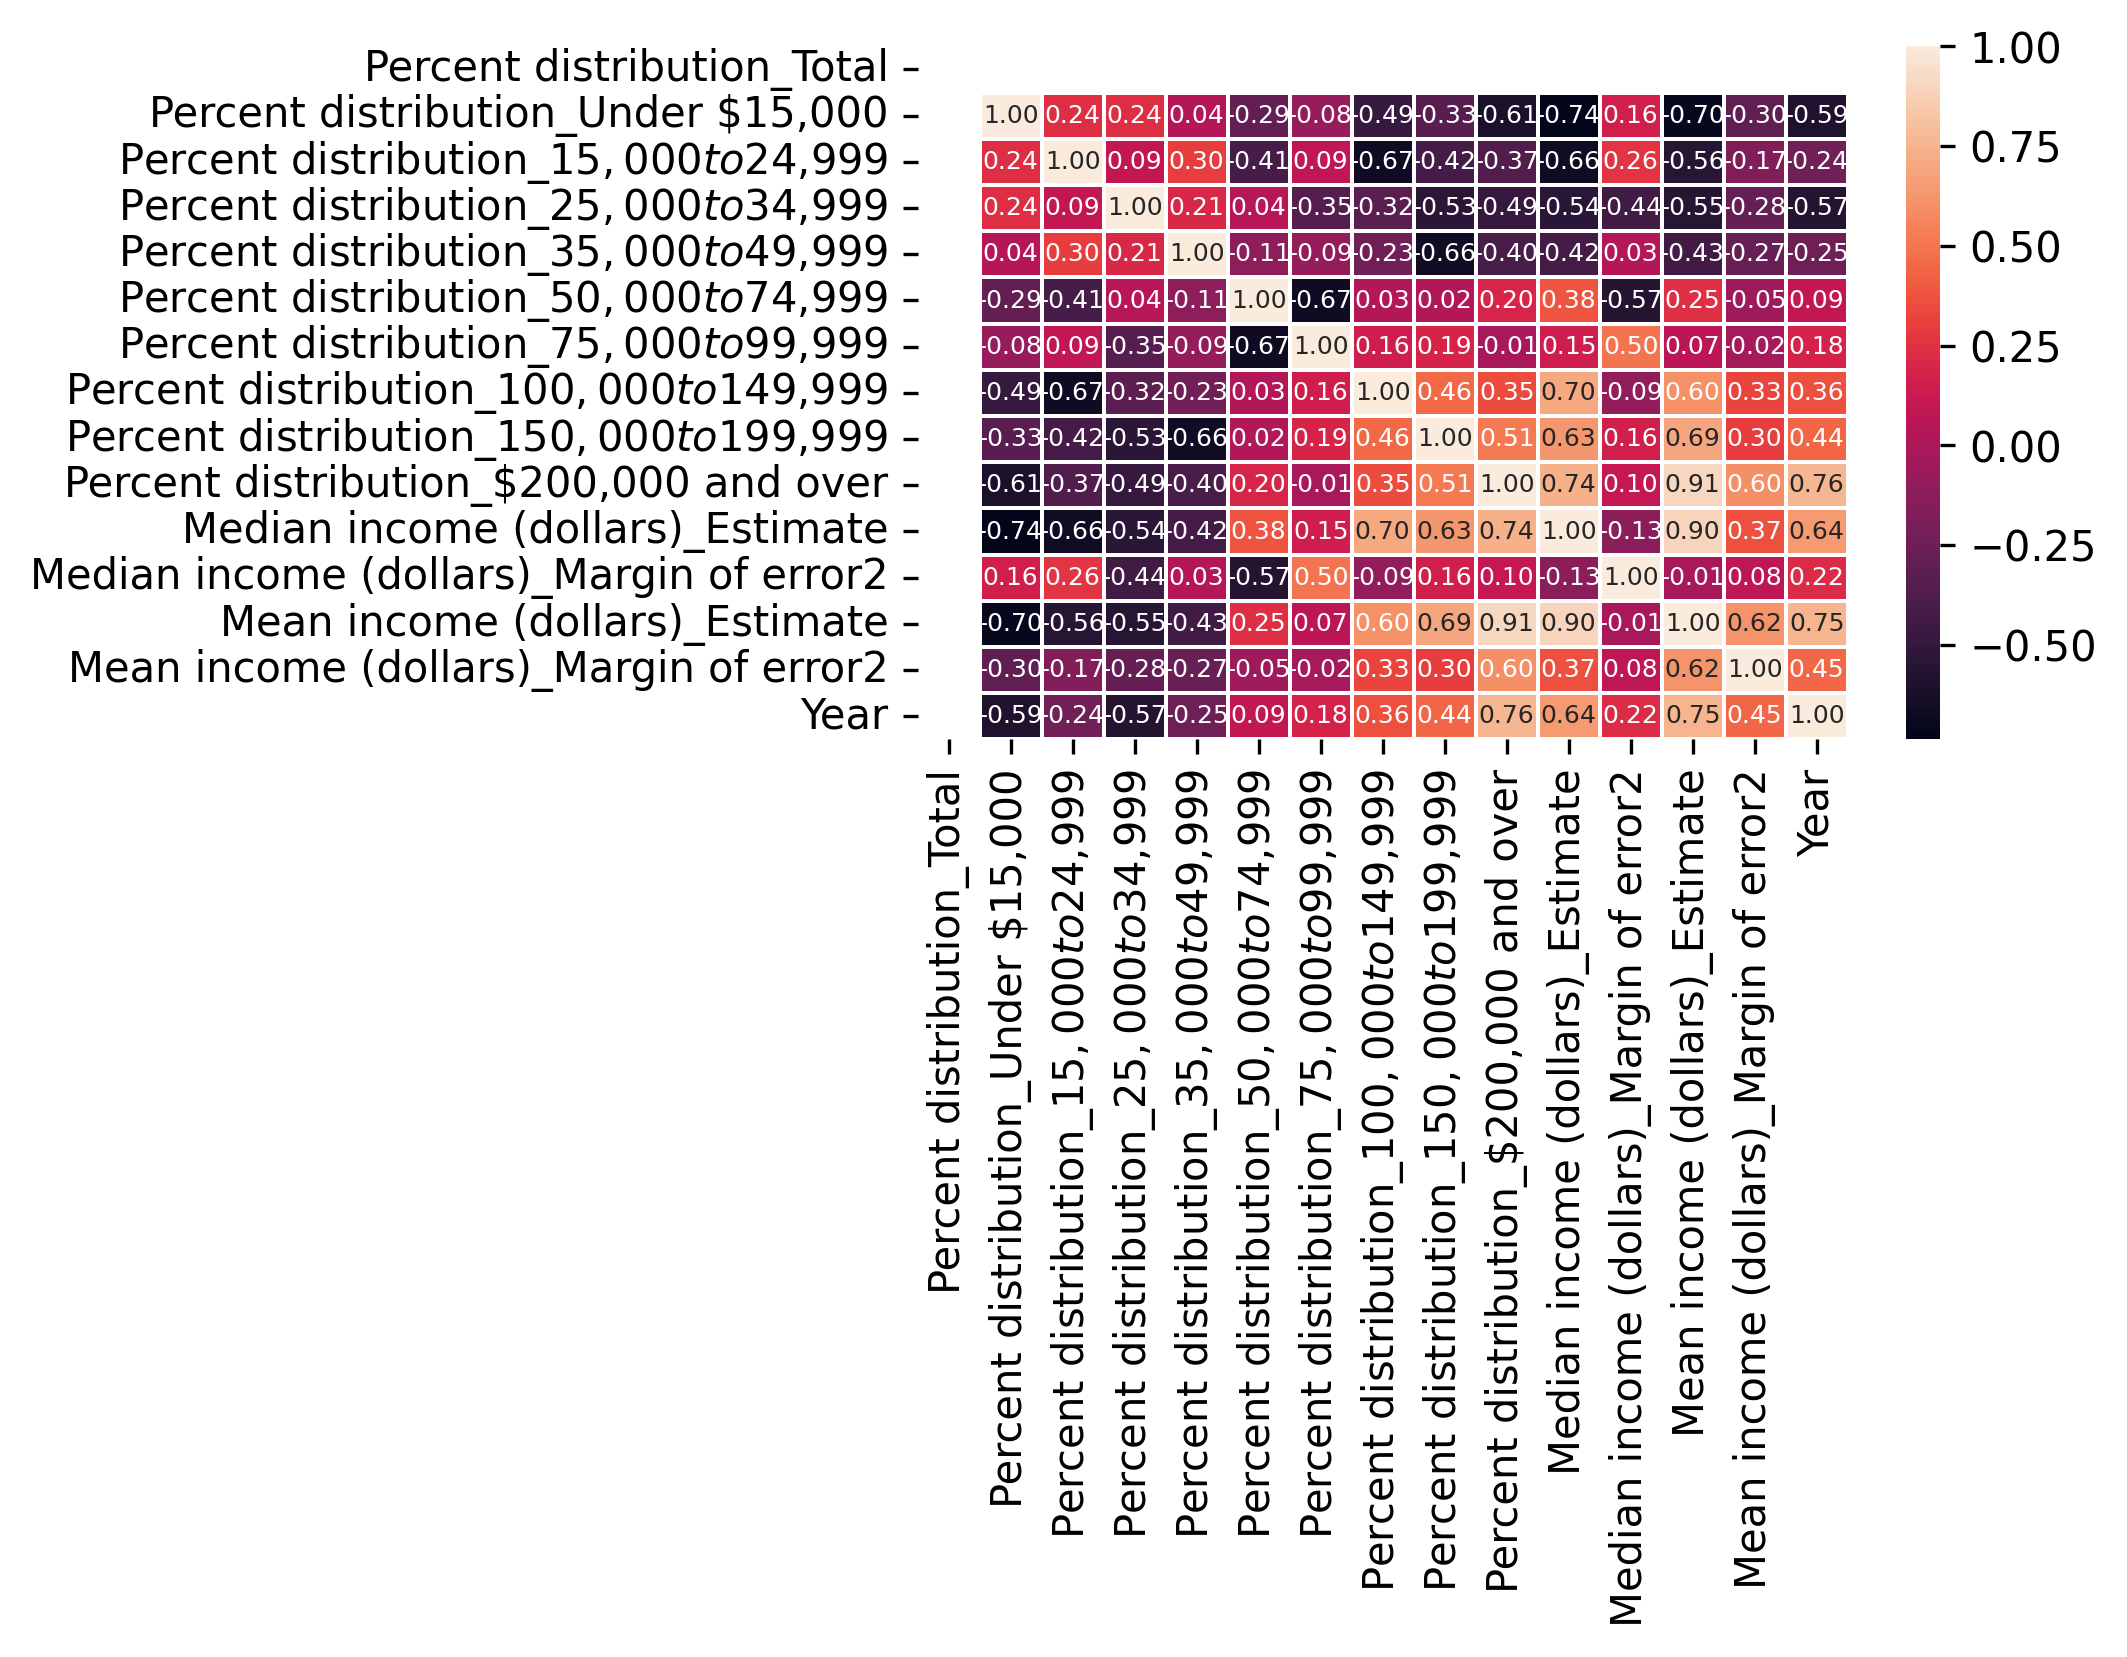

In [97]:
ta2_complete["Median income (dollars)_Margin of error2"] = ta2_complete["Median income (dollars)_Margin of error2"].astype(float)
ta2_complete["Mean income (dollars)_Estimate"] = ta2_complete["Mean income (dollars)_Estimate"].astype(float)
ta2_complete["Mean income (dollars)_Margin of error2"] = ta2_complete["Mean income (dollars)_Margin of error2"].astype(float)
ta2_complete["Year"] = ta2_complete["Year"].astype(int)

correlation_matrix = ta2_complete.corr(method="pearson", numeric_only=True)
plt.figure(figsize=(5,3), dpi =300)
sns.heatmap(correlation_matrix,annot=True,annot_kws={"size": 6}, fmt=".2f", linewidth=.5)
plt.show()

In [98]:
X = ta2_complete[['Percent distribution_$75,000 to $99,999', 'Year']]
y = ta2_complete['Median income (dollars)_Margin of error2']

model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: -0.7973380381258478


In [99]:
X_mean = ta2_complete[['Percent distribution_$200,000 and over', 'Mean income (dollars)_Estimate', 'Year']]
y_mean = ta2_complete['Mean income (dollars)_Margin of error2']

model = LinearRegression()
scores = cross_val_score(model, X_mean, y_mean, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: -0.9160162947099098


In [100]:
# a and c. impute missing value using ffill

tableA2["Number (thousands)"].fillna(method="ffill", inplace=True)
tableA2["Mean income (dollars)_Estimate"].fillna(method="ffill", inplace=True)

condition1 = (tableA2['Race Category'] != 'American Indian and Alaska Native') & (tableA2['Median income (dollars)_Margin of error2'].isnull())
tableA2.loc[condition1, 'Median income (dollars)_Margin of error2'] = tableA2['Median income (dollars)_Margin of error2'].ffill()

condition2 = (tableA2['Race Category'] != 'American Indian and Alaska Native') & (tableA2['Mean income (dollars)_Margin of error2'].isnull())
tableA2.loc[condition2, 'Mean income (dollars)_Margin of error2'] = tableA2['Mean income (dollars)_Margin of error2'].ffill()

Since the "Median Income (dollars)_Estimate" is available when the "margin of error" is missing, we calculate the ratio of margin of error over the median income across the available years from the calculated data we calculate the median of the ratio and impute this as the ratio for the missing values. we then recalculated the margin of error using imputed ratio times median income.

In [101]:
# b. impute using median, margin of error ratio

ta2_complete['MoE_ratio'] = ta2_complete['Median income (dollars)_Margin of error2'] / ta2_complete['Median income (dollars)_Estimate']
imputed_ratio = round(ta2_complete['MoE_ratio'].median(),3)

mask1 = tableA2['Median income (dollars)_Margin of error2'].isna()
tableA2.loc[mask1, 'Median income (dollars)_Margin of error2'] = (tableA2.loc[mask1, 'Median income (dollars)_Estimate'] * imputed_ratio).round(0)

ta2_complete['MoE_mean_ratio'] = ta2_complete['Mean income (dollars)_Margin of error2'] / ta2_complete['Mean income (dollars)_Estimate']
imputed_ratio_mean = round(ta2_complete['MoE_mean_ratio'].median(),3)

mask2 = tableA2['Mean income (dollars)_Margin of error2'].isna()
tableA2.loc[mask2, 'Mean income (dollars)_Margin of error2'] = (tableA2.loc[mask2, 'Mean income (dollars)_Estimate'] * imputed_ratio_mean).round(0)

In [102]:
tableA2.isna().sum()

,0
Year_footnote,0
Race Category,0
Number (thousands),0
Percent distribution_Total,0
"Percent distribution_Under $15,000",0
"Percent distribution_$15,000 to $24,999",0
"Percent distribution_$25,000 to $34,999",0
"Percent distribution_$35,000 to $49,999",0
"Percent distribution_$50,000 to $74,999",0
"Percent distribution_$75,000 to $99,999",0


5. Duplicate values

  The duplicate values happended in year 2017 and 2013.

  The reason of duplicate values are mainly due to
  1. For year 2017, the duplicate is due to an updated processing system
  2. For year 2013, the duplicate is due to redesigned questions.

  Our solution is to remove the old record and keep the updated records as it is more suitable for comparison with subsequent years, since it reflected the new system / methodology.

In [103]:
#identified 22 duplicate years

duplicate_ta2=identify_duplicate(tableA2, False)
duplicate_ta2

{'All Races': array(['2017', '2013'], dtype=object),
 'White Alone': array(['2017', '2013'], dtype=object),
 'White Alone, Not Hispanic': array(['2017', '2013'], dtype=object),
 'Black Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Black Alone': array(['2017', '2013'], dtype=object),
 'Asian Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Asian Alone': array(['2017', '2013'], dtype=object),
 'American Indian and Alaska Native Alone or in Combination': array(['2017', '2013'], dtype=object),
 'American Indian and Alaska Native Alone': array(['2017', '2013'], dtype=object),
 'Two or More Races': array(['2017', '2013'], dtype=object),
 'Hispanic (any race)': array(['2017', '2013'], dtype=object)}

In [104]:
tableA2['Year_footnote'] = tableA2['Year_footnote'].astype(str)
tableA2 = tableA2[(tableA2['Year_footnote'] != '2017') & (tableA2['Year_footnote'] != '2013 5')]
tableA2 = tableA2.drop(columns=['Year_footnote'])

In [105]:
duplicate_ta2=identify_duplicate(tableA2, False)
duplicate_ta2

{}

In [106]:
# impute the missing years for table A2 using extrapolation method, since the missing year is at the start of the dataset

missing_years = list(range(1959, 1967))  # 1959 to 1966 inclusive
tableA2['Year'] = pd.to_numeric(tableA2['Year'], errors='coerce')
tableA2 = tableA2.sort_values(by=['Race Category', 'Year'])

exclude_cols = ['Race Category', 'Year','missing_value']
numeric_cols = [col for col in tableA2.columns if col not in exclude_cols]

races_to_extrapolate = ['All Races', 'White']

extrapolated_rows = []

for race, group in tableA2.groupby('Race Category'):
    if race not in races_to_extrapolate:
        continue

    group = group.sort_values('Year')

    valid_group = group[group['Year'] >= 1967]

    extrapolated_data = {'Race Category': [race] * len(missing_years), 'Year': missing_years}

    for col in numeric_cols:
        col_data = valid_group[['Year', col]].dropna()
        if len(col_data) < 2:
            extrapolated_data[col] = [np.nan] * len(missing_years)
            continue

        f = interp1d(col_data['Year'], col_data[col], kind='linear', fill_value='extrapolate', bounds_error=False)
        extrapolated_data[col] = f(missing_years)

    extrapolated_rows.append(pd.DataFrame(extrapolated_data))

if extrapolated_rows:
    extrapolated_df = pd.concat(extrapolated_rows, ignore_index=True)
    tableA2 = pd.concat([tableA2, extrapolated_df], ignore_index=True)

tableA2 = tableA2.sort_values(by=['Race Category', 'Year']).reset_index(drop=True)

#### tableA3

1. Understand the data structure

In [107]:
tableA3 = pd.read_excel(os.path.join(data_dir, 'tableA3.xlsx'))

structure_ta3 = tableA3.dtypes
shape_ta3 = tableA3.shape
print(structure_ta3, shape_ta3)

Year                                        int64
Race Category                              object
All people_Total                           object
All people_Below poverty_Number            object
All people_Below poverty_Percent           object
Under 18 years_Total                       object
Under 18 years_Below poverty_Number        object
Under 18 years_Below poverty_Percent       object
18 to 64 years_Total                       object
18 to 64 years_Below poverty_Number        object
18 to 64 years_Below poverty_Percent       object
65 years and over_Total                    object
65 years and over_Below poverty_Number     object
65 years and over_Below poverty_Percent    object
dtype: object (470, 14)


2. Change the column "Year" to "Year_footnote", and create a new column "Year"
    
    The Year_footnote will stored both the year and footnote information, while the "Year" will only stored year data without footnote

In [108]:
tableA3 = tableA3.rename(columns={'Year': 'Year_footnote'})
tableA3["Year"] = tableA3["Year_footnote"].astype(str).str.extract(r'(\d{4})')

3. Identify missing value

    Missing value was labeled as "N" and "(B)" in the raw data
    
    We first replaced the character "N" and "(B)" to NaN, then we fill in the missing value using appropriate imputation method

In [109]:
tableA3.replace("N", pd.NA, inplace=True)
tableA3.replace("(B)", pd.NA, inplace=True)
tableA3.isna().sum()

tableA3['missing_value'] = tableA3.isnull().any(axis=1).map({True: 'Yes', False: 'No'})

Missing value

1. Observation & solution
    Observation: 1 missing value in column "All people_Total", "All people_Below poverty_Number","All people_Below poverty_Percent" for race category " Black" in the first year, ie 1965
    Solution: use forward fill to fill in the missing value since there is only 1 missing value and appear in the earliest year, ie 1965

2. Observation & solution


4. Impute missing value

|No|Year | Race Category| Column|Imputation Method|
|--|-----|---------------|------|-----------------|
|a|1965|Black|All people_Total,All people_Below poverty_Number,All people_Below poverty_Percent|forward fill using earliest available data|
|b|1959-1973|White|All columns except "All people" column|regression-based imputation method and forward fill for column "65 years and over" as it has weak correlation and only 2 missing value|
|c|1960-1965|All Races|18 to 64 years_Total, 18 to 64 years_Below poverty_Number, 18 to 64 years_Below poverty_Percent, 65 years and over_Total, 65 years and over_Below poverty_Number, 65 years and over_Below poverty_Percent |regression-based imputation method|
|d|1973-1975|Hispanic (Any Race)|Under 18 years_Total,Under 18 years_Below poverty_Number,Under 18 years_Below poverty_Percent, 18 to 64 years_Total, 18 to 64 years_Below poverty_Number, 18 to 64 years_Below poverty_Percent, 65 years and over_Total |regression-based imputation method|
|e|1965-1973|Black|Under 18 years_Total,Under 18 years_Below poverty_Number,Under 18 years_Below poverty_Percent, 18 to 64 years_Total, 18 to 64 years_Below poverty_Number, 18 to 64 years_Below poverty_Percent |regression-based imputation method|

In [110]:
# a. impute using forward fill

tableA3["All people_Total"].fillna(method="ffill", inplace=True)
tableA3["All people_Below poverty_Number"].fillna(method="ffill", inplace=True)
tableA3["All people_Below poverty_Percent"].fillna(method="ffill", inplace=True)

In [111]:
ta3 = tableA3[(tableA3['Race Category'] == "White")]
ta3_complete = ta3.dropna()
ta3_complete = ta3_complete.drop(["Race Category",'missing_value'], axis=1)

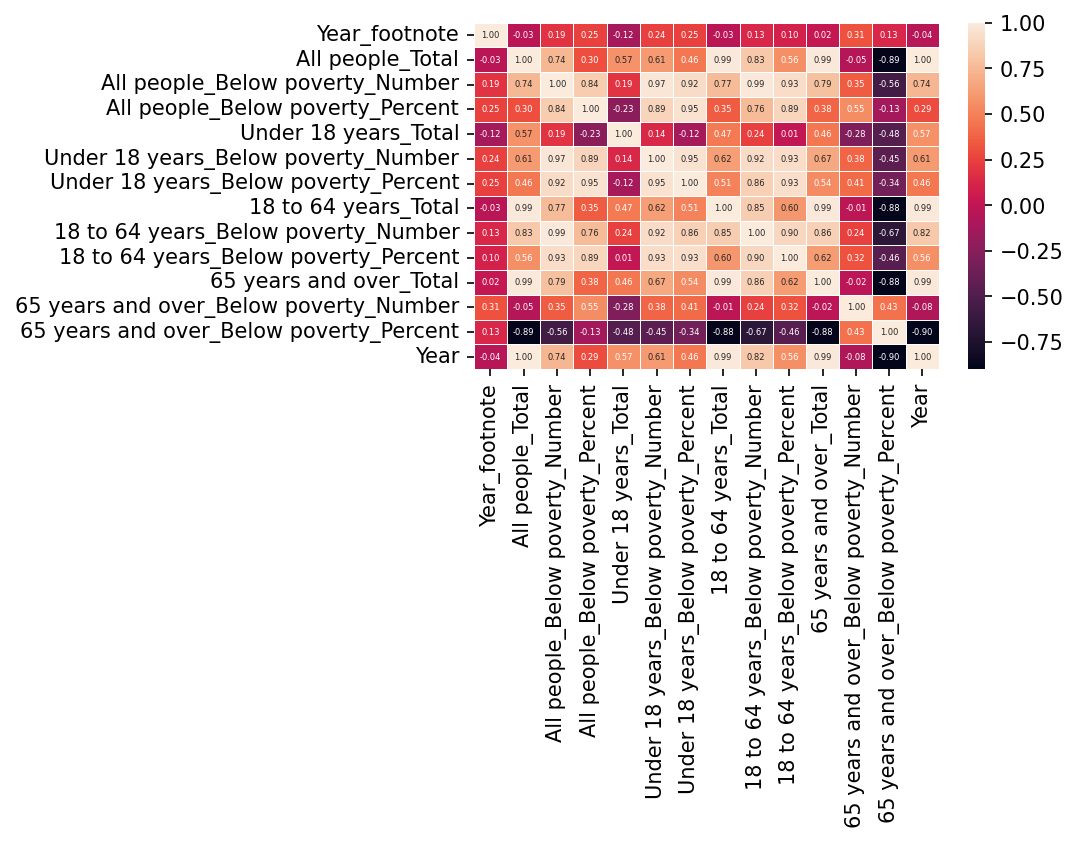

In [112]:
ta3_complete=ta3_complete.astype(int)
correlation_matrix = ta3_complete.corr(method="pearson", numeric_only=True)
plt.figure(figsize=(5,3), dpi =150)
sns.heatmap(correlation_matrix,annot=True,annot_kws={"size": 4}, fmt=".2f", linewidth=.3)
plt.show()

In [113]:
# b. impute using regression-based method
# missing value in race category: White, column "Under 18 years_Below poverty_Number"

X_train = ta3_complete[['All people_Total', 'All people_Below poverty_Number', 'All people_Below poverty_Percent', 'Year']]
y_train = ta3_complete['Under 18 years_Below poverty_Number']

model = LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: 0.6010048283876419


In [114]:
ta3_missing = ta3[ta3['Under 18 years_Below poverty_Number'].isna()]

model.fit(X_train, y_train)
X_missing = ta3_missing[['All people_Total', 'All people_Below poverty_Number', 'All people_Below poverty_Percent', 'Year']]
ta3_missing['Under 18 years_Below poverty_Number'] = model.predict(X_missing).round()

In [115]:
# b. impute using regression-based method
# missing value in race category: White, column "Under 18 years_Below poverty_Percent"

X_train2 = ta3_complete[['All people_Total', 'All people_Below poverty_Number', 'All people_Below poverty_Percent']]
y_train2 = ta3_complete['Under 18 years_Below poverty_Percent']

model = LinearRegression()
scores = cross_val_score(model, X_train2, y_train2, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: 0.48917540795632225


In [116]:
model.fit(X_train2, y_train2)
X_missing = ta3_missing[['All people_Total', 'All people_Below poverty_Number', 'All people_Below poverty_Percent']]
ta3_missing['Under 18 years_Below poverty_Percent'] = model.predict(X_missing).round(1)

Missing value in column "65 years and over_Below poverty_Number" and '65 years and over_Below poverty_Percent' have a weak correlation with other attributes, hence regression-based imputation is not a suitable method, since there is only 2 missing value, hence we will use the forward fill method to fill in the missing value

In [117]:
ta3_missing["65 years and over_Below poverty_Percent"].fillna(method="ffill", inplace=True)
ta3_missing["65 years and over_Below poverty_Number"].fillna(method="ffill", inplace=True)

mask = ta3_missing['65 years and over_Total'].isna()
ta3_missing.loc[mask, '65 years and over_Total'] = (ta3_missing.loc[mask, '65 years and over_Below poverty_Number'] / (ta3_missing.loc[mask, '65 years and over_Below poverty_Percent'] /100)).round()


mask = ta3_missing['Under 18 years_Total'].isna()
ta3_missing.loc[mask, 'Under 18 years_Total'] = (ta3_missing.loc[mask, 'Under 18 years_Below poverty_Number'] / (ta3_missing.loc[mask, 'Under 18 years_Below poverty_Percent'] /100)).round()

mask = ta3_missing['18 to 64 years_Total'].isna()
ta3_missing.loc[mask, '18 to 64 years_Total'] = (ta3_missing.loc[mask, 'All people_Total'] -ta3_missing.loc[mask, 'Under 18 years_Total'] -ta3_missing.loc[mask, '65 years and over_Total']).round()

mask = ta3_missing['18 to 64 years_Below poverty_Number'].isna()
ta3_missing.loc[mask, '18 to 64 years_Below poverty_Number'] = (ta3_missing.loc[mask, 'All people_Below poverty_Number'] -ta3_missing.loc[mask, 'Under 18 years_Below poverty_Number']
                                                                     -ta3_missing.loc[mask, '65 years and over_Below poverty_Number']).round()


mask = ta3_missing['18 to 64 years_Below poverty_Percent'].isna()
ta3_missing.loc[mask, '18 to 64 years_Below poverty_Percent'] = (ta3_missing.loc[mask, '18 to 64 years_Below poverty_Number'] / (ta3_missing.loc[mask, '18 to 64 years_Total']) *100).round(1)


In [118]:
# c. impute using regression-based method

ta3_all_races = tableA3[(tableA3['Race Category'] == "All Races")]
ta3_allrace_complete = ta3_all_races.dropna()
ta3_allrace_complete = ta3_allrace_complete.drop(["Race Category",'missing_value'], axis=1)

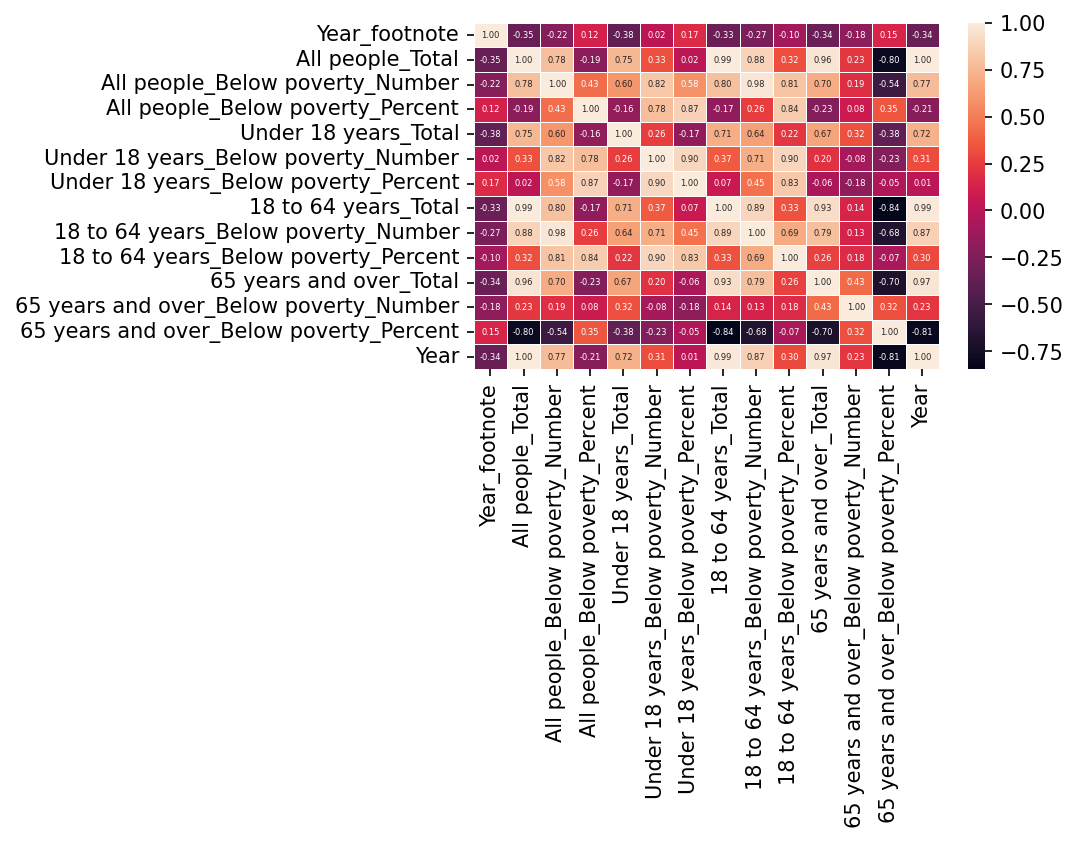

In [119]:
ta3_allrace_complete=ta3_allrace_complete.astype(int)
correlation_matrix = ta3_allrace_complete.corr(method="pearson", numeric_only=True)
plt.figure(figsize=(5,3), dpi =150)
sns.heatmap(correlation_matrix,annot=True,annot_kws={"size": 4}, fmt=".2f", linewidth=.3)
plt.show()

In [120]:
# c. impute using regression-based method
# missing value in race category: All Races, column "18 to 64 years_Below poverty_Number"

X_train_ar2 = ta3_allrace_complete[['All people_Below poverty_Number','Year']]
y_train_ar2 = ta3_allrace_complete['18 to 64 years_Below poverty_Number']

model = LinearRegression()
scores = cross_val_score(model, X_train_ar2, y_train_ar2, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: 0.8083066062752579


In [121]:
ta3_allraces_missing = ta3_all_races[ta3_all_races['18 to 64 years_Total'].isna()]

model.fit(X_train_ar2, y_train_ar2)
X_missing = ta3_allraces_missing[['All people_Below poverty_Number','Year']]
ta3_allraces_missing['18 to 64 years_Below poverty_Number'] = model.predict(X_missing).round()

In [122]:
# c. impute using regression-based method
# missing value in race category: All Race, column "18 to 64 years_Below poverty_Percent"

X_train_ar1 = ta3_allrace_complete[['All people_Below poverty_Percent','Year' ]]

y_train_ar1 = ta3_allrace_complete['18 to 64 years_Below poverty_Percent']

model = LinearRegression()
scores = cross_val_score(model, X_train_ar1, y_train_ar1, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: 0.8618875307425877


In [123]:
model.fit(X_train_ar1, y_train_ar1)
X_missing = ta3_allraces_missing[['All people_Below poverty_Percent','Year' ]]
ta3_allraces_missing['18 to 64 years_Below poverty_Percent'] = model.predict(X_missing).round(2)

In [124]:
mask = ta3_allraces_missing['18 to 64 years_Total'].isna()
ta3_allraces_missing.loc[mask, '18 to 64 years_Total'] = (ta3_allraces_missing.loc[mask, '18 to 64 years_Below poverty_Number'] / (ta3_allraces_missing.loc[mask, '18 to 64 years_Below poverty_Percent'] /100)).round(0)

mask = ta3_allraces_missing['65 years and over_Total'].isna()
ta3_allraces_missing.loc[mask, '65 years and over_Total'] = (ta3_allraces_missing.loc[mask, 'All people_Total'] -ta3_allraces_missing.loc[mask, 'Under 18 years_Total']
                                                                     -ta3_allraces_missing.loc[mask, '18 to 64 years_Total']).round()

mask = ta3_allraces_missing['65 years and over_Below poverty_Number'].isna()
ta3_allraces_missing.loc[mask, '65 years and over_Below poverty_Number'] = (ta3_allraces_missing.loc[mask, 'All people_Below poverty_Number'] -ta3_allraces_missing.loc[mask, 'Under 18 years_Below poverty_Number']
                                                                     -ta3_allraces_missing.loc[mask, '18 to 64 years_Below poverty_Number']).round()

mask = ta3_allraces_missing['65 years and over_Below poverty_Percent'].isna()
ta3_allraces_missing.loc[mask, '65 years and over_Below poverty_Percent'] = ((ta3_allraces_missing.loc[mask, '65 years and over_Below poverty_Number'] / ta3_allraces_missing.loc[mask, '65 years and over_Total']) *100).round(1)



In [125]:
# d. impute using regression-based method
# missing value in race category : Hispanic (Any Race)

ta3_hisp = tableA3[(tableA3['Race Category'] == "Hispanic (any race)")]
ta3_hisp_complete = ta3_hisp.dropna()
ta3_hisp_complete = ta3_hisp_complete.drop(["Race Category",'missing_value'], axis=1)

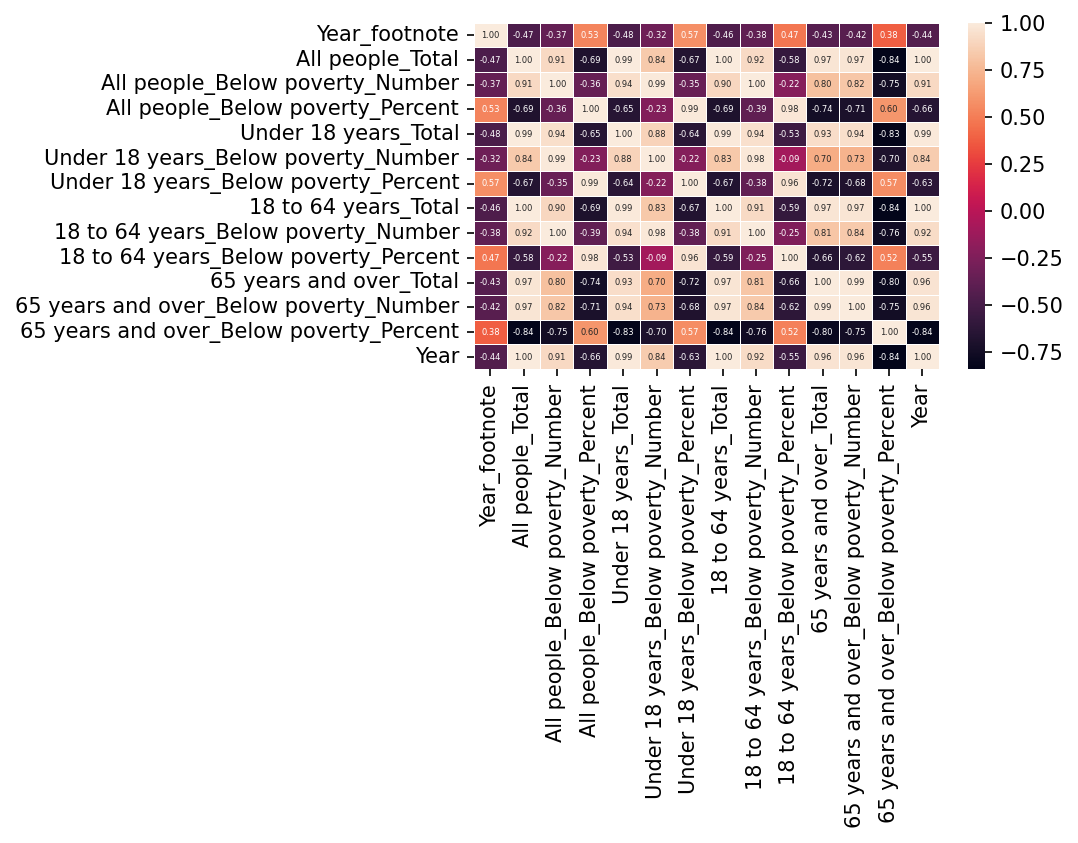

In [126]:
ta3_hisp_complete=ta3_hisp_complete.astype(int)
correlation_matrix = ta3_hisp_complete.corr(method="pearson", numeric_only=True)
plt.figure(figsize=(5,3), dpi =150)
sns.heatmap(correlation_matrix,annot=True,annot_kws={"size": 4}, fmt=".2f", linewidth=.3)
plt.show()

In [127]:
# d. impute using regression-based method
# missing value in race category: Hispanic (Any Race), column "Under 18 years_Below poverty_Number"

X_train_hisp1 = ta3_hisp_complete[['All people_Total', 'All people_Below poverty_Number','Year']]
y_train_hisp1 = ta3_hisp_complete['Under 18 years_Below poverty_Number']

model = LinearRegression()
scores = cross_val_score(model, X_train_hisp1, y_train_hisp1, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: 0.8698133604214948


In [128]:
ta3_hisp_missing = ta3_hisp[ta3_hisp['Under 18 years_Below poverty_Number'].isna()]

model.fit(X_train_hisp1, y_train_hisp1)
X_missing = ta3_hisp_missing[['All people_Total', 'All people_Below poverty_Number','Year']]
ta3_hisp_missing['Under 18 years_Below poverty_Number'] = model.predict(X_missing).round()

In [129]:
# d. impute using regression-based method
# missing value in race category: Hispanic (Any Race), column "Under 18 years_Below poverty_Percent"

X_train_hisp2 = ta3_hisp_complete[['All people_Below poverty_Percent']]
y_train_hisp2 = ta3_hisp_complete['Under 18 years_Below poverty_Percent']

model = LinearRegression()
scores = cross_val_score(model, X_train_hisp2, y_train_hisp2, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: 0.7825280812233564


In [130]:
model.fit(X_train_hisp2, y_train_hisp2)
X_missing = ta3_hisp_missing[['All people_Below poverty_Percent']]
ta3_hisp_missing['Under 18 years_Below poverty_Percent'] = model.predict(X_missing).round()

In [131]:
mask = ta3_hisp_missing['65 years and over_Total'].isna()
ta3_hisp_missing.loc[mask, '65 years and over_Total'] = (ta3_hisp_missing.loc[mask, '65 years and over_Below poverty_Number'] / (ta3_hisp_missing.loc[mask, '65 years and over_Below poverty_Percent'] /100)).round(0).astype(int)


mask = ta3_hisp_missing['Under 18 years_Total'].isna()
ta3_hisp_missing.loc[mask, 'Under 18 years_Total'] = (ta3_hisp_missing.loc[mask, 'Under 18 years_Below poverty_Number'] / (ta3_hisp_missing.loc[mask, 'Under 18 years_Below poverty_Percent'] /100)).round()

mask = ta3_hisp_missing['18 to 64 years_Total'].isna()
ta3_hisp_missing.loc[mask, '18 to 64 years_Total'] = (ta3_hisp_missing.loc[mask, 'All people_Total'] -ta3_hisp_missing.loc[mask, 'Under 18 years_Total'] -ta3_hisp_missing.loc[mask, '65 years and over_Total']).round()

mask = ta3_hisp_missing['18 to 64 years_Below poverty_Number'].isna()
ta3_hisp_missing.loc[mask, '18 to 64 years_Below poverty_Number'] = (ta3_hisp_missing.loc[mask, 'All people_Below poverty_Number'] -ta3_hisp_missing.loc[mask, 'Under 18 years_Below poverty_Number']
                                                                     -ta3_hisp_missing.loc[mask, '65 years and over_Below poverty_Number']).round()


mask = ta3_hisp_missing['18 to 64 years_Below poverty_Percent'].isna()
ta3_hisp_missing.loc[mask, '18 to 64 years_Below poverty_Percent'] = (ta3_hisp_missing.loc[mask, '18 to 64 years_Below poverty_Number'] / (ta3_hisp_missing.loc[mask, '18 to 64 years_Total']) *100).round(1)


In [132]:
# e. Impute using regression-based method
# missing value in race category: Black

ta3_black = tableA3[(tableA3['Race Category'] == "Black")]
ta3_b_complete = ta3_black.dropna()
ta3_b_complete = ta3_b_complete.drop(["Race Category",'missing_value'], axis=1)

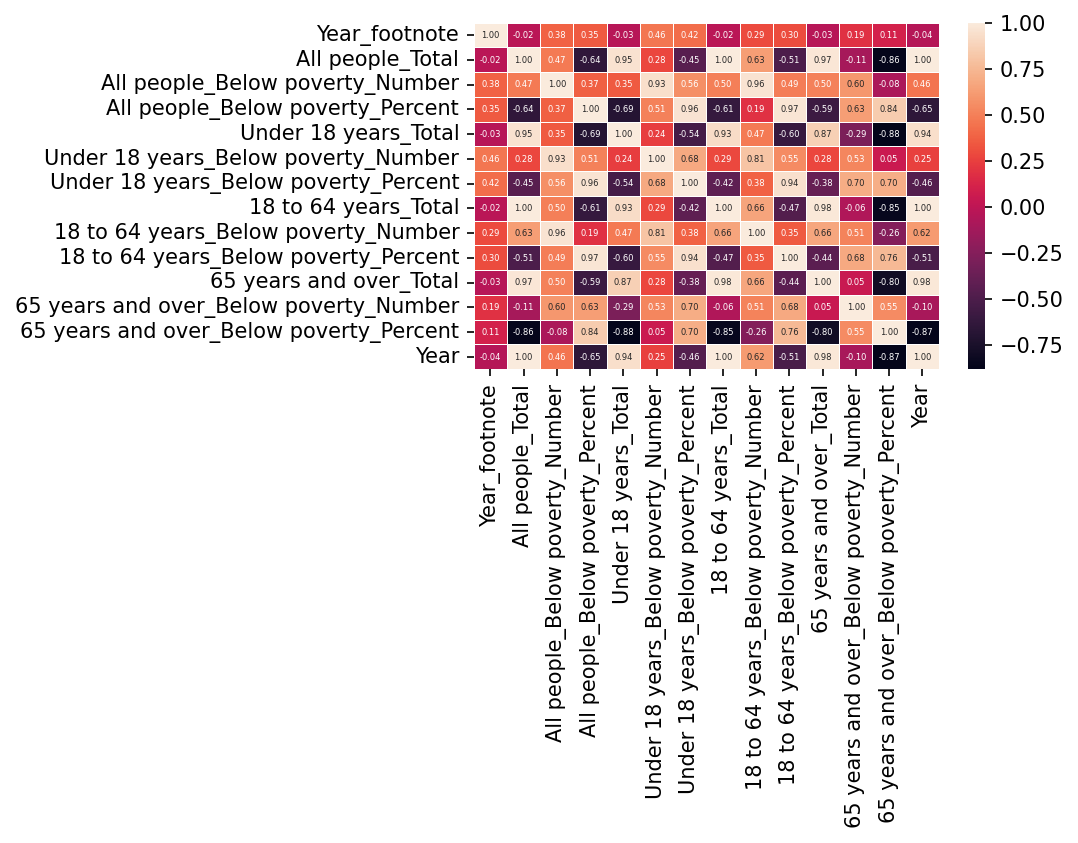

In [133]:
ta3_b_complete=ta3_b_complete.astype(int)
correlation_matrix = ta3_b_complete.corr(method="pearson", numeric_only=True)
plt.figure(figsize=(5,3), dpi =150)
sns.heatmap(correlation_matrix,annot=True,annot_kws={"size": 4}, fmt=".2f", linewidth=.3)
plt.show()

In [134]:
# e. Impute using regression-based method
# missing value in race category: Black, column "18 to 64 years_Total"

X_train_b1 = ta3_b_complete[['All people_Total','Year']]
y_train_b1 = ta3_b_complete['18 to 64 years_Total']

model = LinearRegression()
scores = cross_val_score(model, X_train_b1, y_train_b1, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: 0.3970401517667611


In [135]:
ta3_b_missing = ta3_black[ta3_black['Under 18 years_Below poverty_Number'].isna()]

model.fit(X_train_b1, y_train_b1)
X_missing = ta3_b_missing[['All people_Total','Year']]
ta3_b_missing['18 to 64 years_Total'] = model.predict(X_missing).round()

In [136]:
# e. Impute using regression-based method
# missing value in race category: Black, column "Under 18 years_Below poverty_Percent"

X_train_b2 = ta3_b_complete[['All people_Below poverty_Percent','65 years and over_Below poverty_Percent','All people_Below poverty_Number','65 years and over_Below poverty_Number', 'Year']]
y_train_b2 = ta3_b_complete['Under 18 years_Below poverty_Percent']

model = LinearRegression()
scores = cross_val_score(model, X_train_b2, y_train_b2, cv=5, scoring='r2')
print("Average R2 score:", np.mean(scores))

Average R2 score: 0.5428329529812008


In [137]:
model.fit(X_train_b2, y_train_b2)
X_missing = ta3_b_missing[['All people_Below poverty_Percent','65 years and over_Below poverty_Percent','All people_Below poverty_Number','65 years and over_Below poverty_Number', 'Year']]
ta3_b_missing['Under 18 years_Below poverty_Percent'] = model.predict(X_missing).round()

In [138]:
mask = ta3_b_missing['65 years and over_Total'].isna()
ta3_b_missing.loc[mask, '65 years and over_Total'] = (ta3_b_missing.loc[mask, '65 years and over_Below poverty_Number'] / (ta3_b_missing.loc[mask, '65 years and over_Below poverty_Percent'] /100)).round(0).astype(int)

mask = ta3_b_missing['Under 18 years_Total'].isna()
ta3_b_missing.loc[mask, 'Under 18 years_Total'] = (ta3_b_missing.loc[mask, 'All people_Total'] -ta3_b_missing.loc[mask, '18 to 64 years_Total']
                                                                     -ta3_b_missing.loc[mask, '65 years and over_Total']).round()

mask = ta3_b_missing['Under 18 years_Below poverty_Number'].isna()
ta3_b_missing.loc[mask, 'Under 18 years_Below poverty_Number'] = (ta3_b_missing.loc[mask, 'Under 18 years_Total'] * (ta3_b_missing.loc[mask, 'Under 18 years_Below poverty_Percent'] /100)).round()

mask = ta3_b_missing['18 to 64 years_Below poverty_Number'].isna()
ta3_b_missing.loc[mask, '18 to 64 years_Below poverty_Number'] = (ta3_b_missing.loc[mask, 'All people_Below poverty_Number'] -ta3_b_missing.loc[mask, 'Under 18 years_Below poverty_Number']
                                                                     -ta3_b_missing.loc[mask, '65 years and over_Below poverty_Number']).round()

mask = ta3_b_missing['18 to 64 years_Below poverty_Percent'].isna()
ta3_b_missing.loc[mask, '18 to 64 years_Below poverty_Percent'] = (ta3_b_missing.loc[mask, '18 to 64 years_Below poverty_Number'] / (ta3_b_missing.loc[mask, '18 to 64 years_Total']) *100).round(1)


In [139]:
# combine missing section with the main table

mask = tableA3.isna().any(axis=1)
new_tableA3 =tableA3[~mask].copy()
new_tableA3 = pd.concat([new_tableA3, ta3_missing, ta3_allraces_missing, ta3_hisp_missing,ta3_b_missing])

new_tableA3 = new_tableA3.sort_values(by=["Race Category","Year"],ascending=[True, False]).reset_index(drop=True)

In [140]:
new_tableA3.isna().sum()

,0
Year_footnote,0
Race Category,0
All people_Total,0
All people_Below poverty_Number,0
All people_Below poverty_Percent,0
Under 18 years_Total,0
Under 18 years_Below poverty_Number,0
Under 18 years_Below poverty_Percent,0
18 to 64 years_Total,0
18 to 64 years_Below poverty_Number,0


5. Duplicate values

  The duplicate values happended in year 2017 and 2013.

  The reason of duplicate values are mainly due to
  1. For year 2017, the duplicate is due to an updated processing system
  2. For year 2013, the duplicate is due to redesigned questions.

  Our solution is to remove the old record and keep the updated records as it is more suitable for comparison with subsequent years, since it reflected the new system / methodology.

In [141]:
# identified 22 duplicate years

duplicate_ta3 = identify_duplicate(new_tableA3, False)
duplicate_ta3

{'All Races': array(['2017', '2013'], dtype=object),
 'American Indian and Alaska Native Alone': array(['2017', '2013'], dtype=object),
 'American Indian and Alaska Native Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Asian Alone': array(['2017', '2013'], dtype=object),
 'Asian Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Black Alone': array(['2017', '2013'], dtype=object),
 'Black Alone or in Combination': array(['2017', '2013'], dtype=object),
 'Hispanic (any race)': array(['2017', '2013'], dtype=object),
 'Two or More Races': array(['2017', '2013'], dtype=object),
 'White Alone': array(['2017', '2013'], dtype=object),
 'White Alone, Not Hispanic': array(['2017', '2013'], dtype=object)}

In [142]:
# remove duplicate values:
# remove year 2017 without footnote (3) or year 2013 with footnote (5)

new_tableA3['Year_footnote'] = new_tableA3['Year_footnote'].astype(str)
new_tableA3 = new_tableA3[(new_tableA3['Year_footnote'] != '2017') & (new_tableA3['Year_footnote'] != '20135')]
new_tableA3 = new_tableA3.drop(columns=['Year_footnote'])

In [143]:
# re-check duplicate:
duplicate_ta3 = identify_duplicate(new_tableA3, False)
duplicate_ta3

{}

### 3.1.2 Merging the table 2, table A2 and table A3

In [144]:
table2 = table2.drop('missing_value', axis=1)
tableA2 = tableA2.drop('missing_value', axis=1)
new_tableA3 = new_tableA3.drop('missing_value', axis=1)

table2['Year'] = table2['Year'].astype(str).str.strip()
tableA2['Year'] = tableA2['Year'].astype(str).str.strip()
new_tableA3['Year'] = new_tableA3['Year'].astype(str).str.strip()

table2['Race Category'] = table2['Race Category'].astype(str).str.strip()
tableA2['Race Category'] = tableA2['Race Category'].astype(str).str.strip()
new_tableA3['Race Category'] = new_tableA3['Race Category'].astype(str).str.strip()

merged_df = table2.merge(tableA2, on=['Year', 'Race Category'], how='outer') \
                  .merge(new_tableA3, on=['Year', 'Race Category'], how='outer')

merged_df = merged_df.sort_values(by=["Race Category","Year"],ascending=[True, False]).reset_index(drop=True)
merged_df.fillna(method='ffill', inplace=True)

# 4. Exploratory Data Analysis (EDA)
**Objective:** Analyze poverty trends from `merge_table.csv`, `table4_clean.csv`, `table6_clean.csv`, and `table7_clean.csv` to understand attributes and key identities of poverty.


In [145]:
# --- 1. Setup ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [146]:
# --- Load All Datasets ---
df_merged = merged_df.copy()
df4 = new_table4.copy()
df6 = new_table6.copy()
df7 = table7.copy()

In [147]:
# --- Initial Data Prep ---
dataframes = {'merged': df_merged, 'table4': df4, 'table6': df6, 'table7': df7}

for name, df in dataframes.items():
    if df is not None:
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)
        df.columns = df.columns.str.strip()
        if 'Year' in df.columns:
            df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

if df_merged is not None:
    print('--- Merged Table Columns ---')
    print(df_merged.columns.tolist())

--- Merged Table Columns ---
['Race Category', 'All people_Total_x', 'All people_Below poverty_Number_x', 'All people_Below poverty_Percent_x', 'People in families_All families_Total', 'People in families_All families_Below poverty_Number', 'People in families_All families_Below poverty_Percent', 'People in families_Families with female householder, no spouse present_Total', 'People in families_Families with female householder, no spouse present_Below poverty_Number', 'People in families_Families with female householder, no spouse present_Below poverty_Percent', 'Unrelated individuals_Total', 'Unrelated individuals_Below poverty_Number', 'Unrelated individuals_Below poverty_Percent', 'Year', 'Number (thousands)', 'Percent distribution_Total', 'Percent distribution_Under $15,000', 'Percent distribution_$15,000 to $24,999', 'Percent distribution_$25,000 to $34,999', 'Percent distribution_$35,000 to $49,999', 'Percent distribution_$50,000 to $74,999', 'Percent distribution_$75,000 to $99,

## 4.1 Analysis of Individual Tables


### 4.1.1 Analysis of Poverty by Family Type



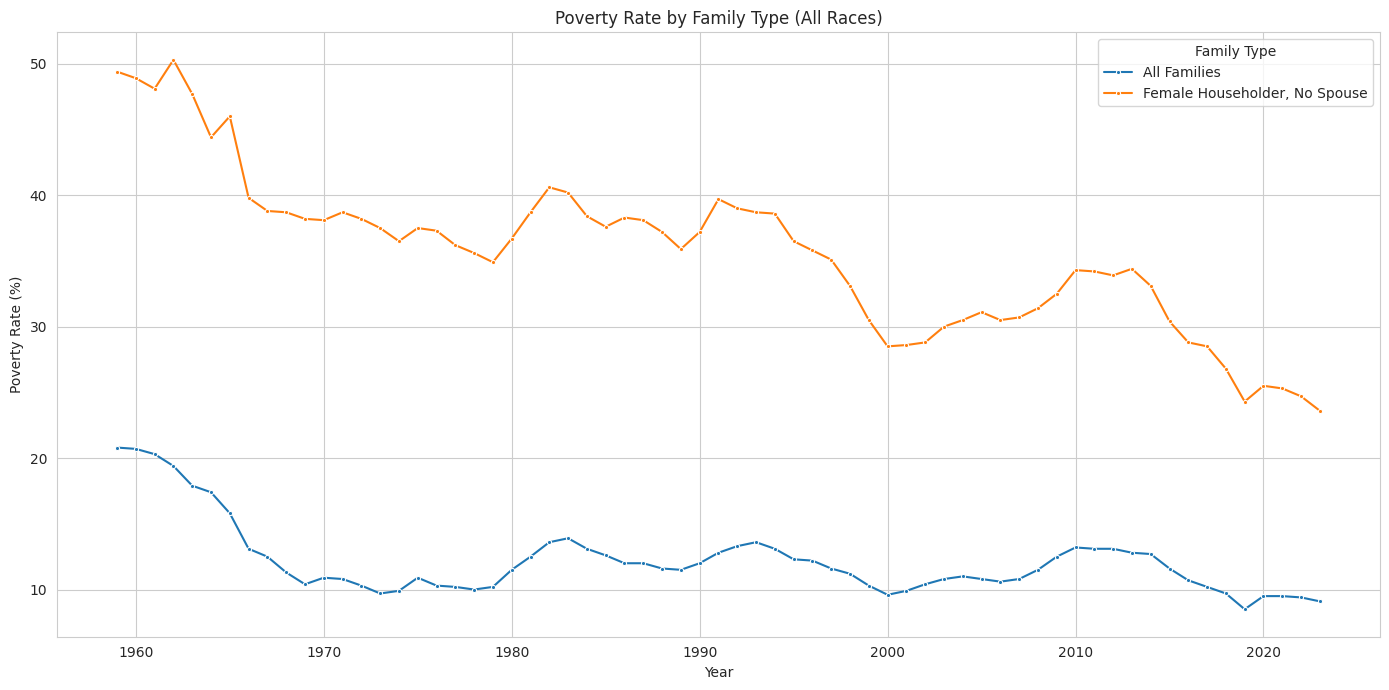

In [148]:
# Plotting family type data, which originates from table4, using the robust df_merged.
if df_merged is not None:
    all_families_col = 'People in families_All families_Below poverty_Percent'
    female_hh_col = 'People in families_Families with female householder, no spouse present_Below poverty_Percent'
    race_col = 'Race Category'

    if race_col in df_merged.columns and 'All Races' in df_merged[race_col].unique():
        df_all_races = df_merged[df_merged[race_col] == 'All Races'].copy()

        if not df_all_races.empty:
            plt.figure(figsize=(14, 7))
            plot_plotted = False

            if all_families_col in df_all_races.columns:
                sns.lineplot(data=df_all_races, x='Year', y=all_families_col, marker='.', label='All Families')
                plot_plotted = True
            if female_hh_col in df_all_races.columns:
                sns.lineplot(data=df_all_races, x='Year', y=female_hh_col, marker='.', label='Female Householder, No Spouse')
                plot_plotted = True

            if plot_plotted:
                plt.title('Poverty Rate by Family Type (All Races)')
                plt.xlabel('Year'); plt.ylabel('Poverty Rate (%)')
                plt.legend(title='Family Type'); plt.grid(True); plt.tight_layout(); plt.show()

Description

* **What it Shows:** This plot from `table4_clean.csv` compares the poverty rate trend for female-headed households against the average for all families.
* **Key Finding(s):**
    * The poverty rate for female-headed households is substantially and consistently higher than the average for all families.
* **Objective Alignment:**
    * This identifies **Family Structure** as a key attribute of poverty.
    * It pinpoints **Female Householder, No Spouse** as a key identity group at high risk of poverty.


 ### 4.1.2 Analysis of Poverty by Age Group

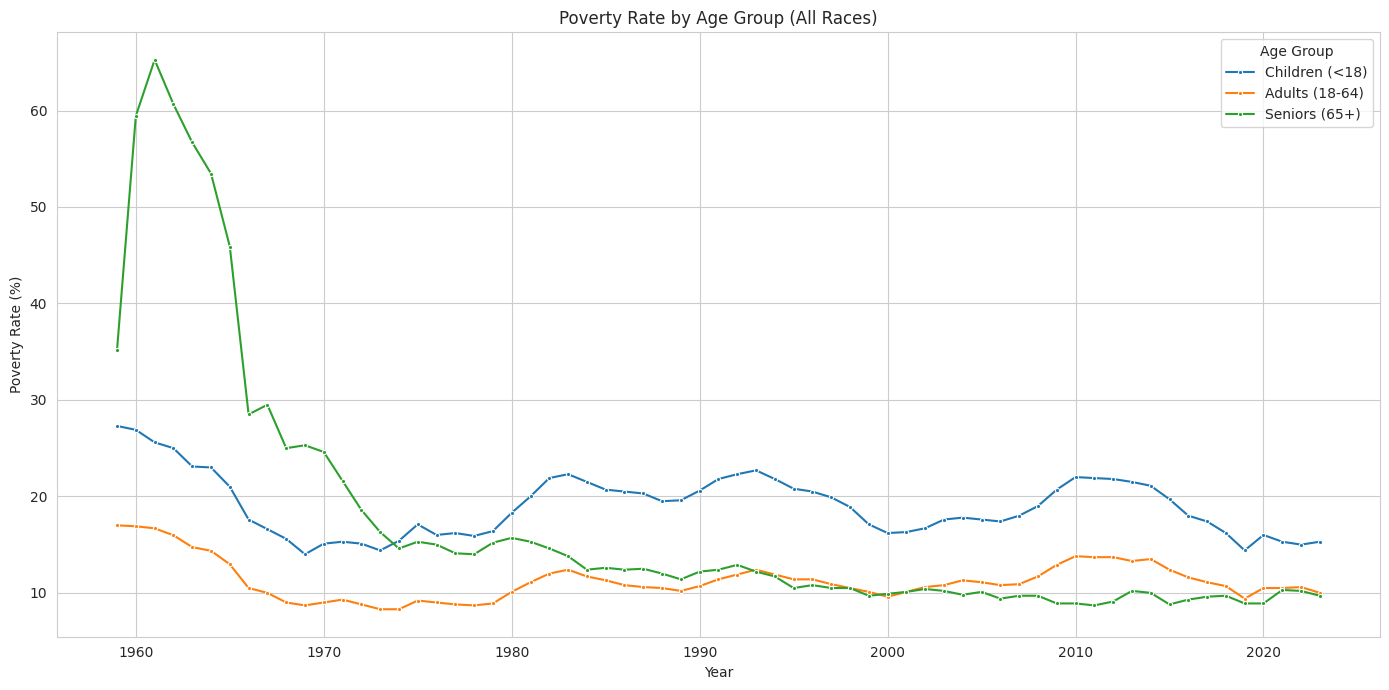

In [149]:
# Plotting age group data, which originates from table7, using the robust df_merged.
if df_merged is not None:
    child_poverty_col = 'Under 18 years_Below poverty_Percent'
    adult_poverty_col = '18 to 64 years_Below poverty_Percent'
    senior_poverty_col = '65 years and over_Below poverty_Percent'

    age_poverty_cols = {
        'Children (<18)': child_poverty_col,
        'Adults (18-64)': adult_poverty_col,
        'Seniors (65+)': senior_poverty_col
    }

    # Focusing on 'All Races' for a clearer trend line
    df_plot = df_merged[df_merged['Race Category'] == 'All Races'].copy()

    if not df_plot.empty:
        plt.figure(figsize=(14, 7))
        plot_plotted = False
        for label, col_name in age_poverty_cols.items():
            if col_name in df_plot.columns:
                sns.lineplot(data=df_plot, x='Year', y=col_name, label=label, marker='.')
                plot_plotted = True
        if plot_plotted:
            plt.title('Poverty Rate by Age Group (All Races)')
            plt.xlabel('Year'); plt.ylabel('Poverty Rate (%)')
            plt.legend(title='Age Group'); plt.grid(True); plt.tight_layout(); plt.show()

Description

* **What it Shows:** This chart from `table7_clean.csv` tracks the poverty rates over time for three distinct age groups: Children (<18), Adults (18-64), and Seniors (65+).
* **Key Finding(s):**
    * Senior poverty was highest before ~1974 but then dropped dramatically.
    * Since ~1974, children have consistently had the highest poverty rate of the three groups.
* **Objective Alignment:**
    * This identifies **Age** as a crucial attribute.
    * It demonstrates that the "key identity" of poverty risk can shift over time, from seniors to children.
    * The sharp decline in senior poverty illustrates that poverty trends can be significantly altered, likely by policy interventions.


### 4.1.3 Analysis of Table 6: Degrees of Poverty

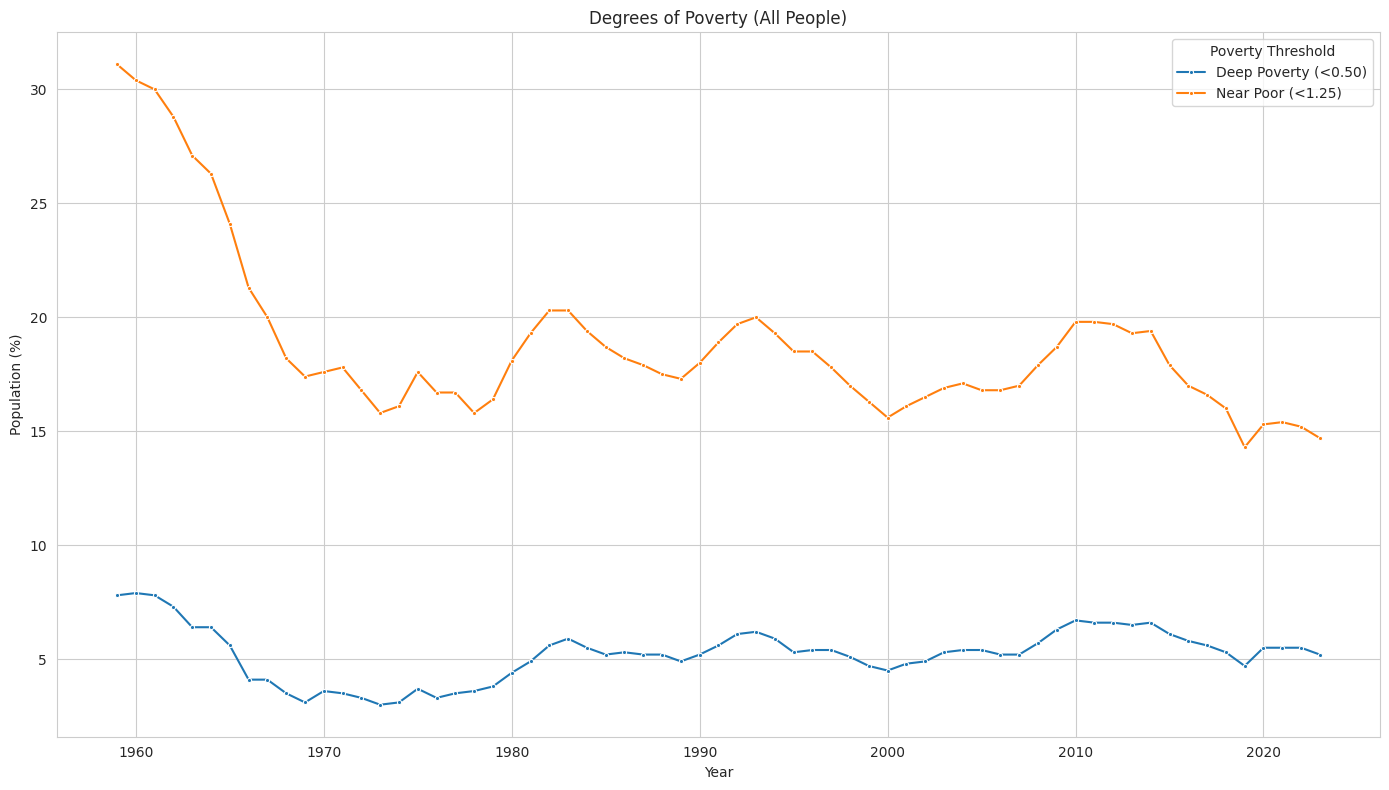

In [150]:
# Plotting degrees of poverty using df6, which contains this specific data.
if df6 is not None:
    degrees_poverty_cols = {
        'Deep Poverty (<0.50)': 'Below 0.50_Percent',
        'Official Poverty (<1.00)': 'Below 1.00_Percent',
        'Near Poor (<1.25)': 'Below 1.25_Percent'
    }

    # This data from table6 does not have a 'Race Category', it is for all people.
    df_plot = df6.copy()

    if not df_plot.empty:
        plt.figure(figsize=(14, 8))
        plot_plotted = False
        for label, col_name in degrees_poverty_cols.items():
            if col_name in df_plot.columns:
                sns.lineplot(data=df_plot, x='Year', y=col_name, label=label, marker='.')
                plot_plotted = True
        if plot_plotted:
            plt.title('Degrees of Poverty (All People)')
            plt.xlabel('Year'); plt.ylabel('Population (%)')
            plt.legend(title='Poverty Threshold'); plt.grid(True); plt.tight_layout(); plt.show()

Description

* **What it Shows:** This chart from `table6_clean.csv` tracks the percentage of the population at different levels relative to the poverty line.
* **Key Finding(s):**
    * A significant portion of the population lives in "Deep Poverty" (below 50% of the poverty line).
    * The trend for "Deep Poverty" does not always perfectly mirror the official poverty rate, suggesting different dynamics for the most vulnerable.
* **Objective Alignment:**
    * This provides a more nuanced understanding of poverty beyond the single official rate.

## 4.2 Integrated Analysis of Merged Data

### 4.2.1 Distribution of Poverty Rates by Race (2002-2023)

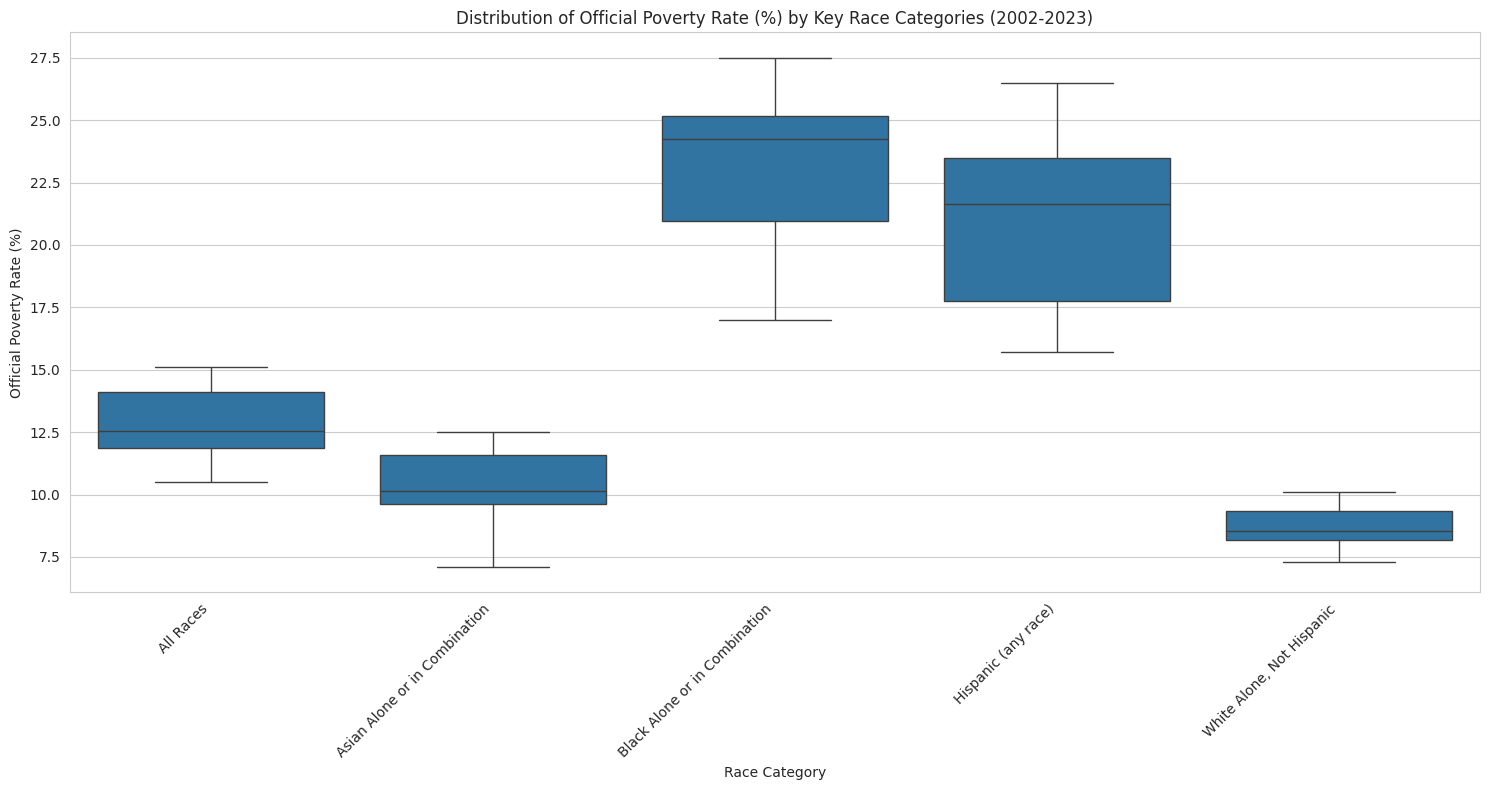

In [151]:
if df_merged is not None:
    official_poverty_col = 'All people_Below poverty_Percent_x'
    race_col = 'Race Category'

    df_2002_onward = df_merged[df_merged['Year'] >= 2002]
    key_races = ['All Races', 'White Alone, Not Hispanic', 'Black Alone or in Combination', 'Asian Alone or in Combination', 'Hispanic (any race)']
    df_filtered_races = df_2002_onward[df_2002_onward[race_col].isin(key_races)]

    if official_poverty_col in df_filtered_races.columns and not df_filtered_races.empty:
        plt.figure(figsize=(15, 8))
        sns.boxplot(data=df_filtered_races, x=race_col, y=official_poverty_col)

        plt.title('Distribution of Official Poverty Rate (%) by Key Race Categories (2002-2023)')
        plt.ylabel('Official Poverty Rate (%)'); plt.xlabel('Race Category')
        plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

Description

* **What it Shows:** This box plot provides a statistical summary of poverty rates for key racial groups for the modern era (2002-2023), allowing for a fair comparison.
* **Key Finding(s):**
    * The median poverty rate (the line in the box) for 'Black Alone or in Combination' and 'Hispanic (any race)' is significantly higher than for 'White Alone, Not Hispanic' and 'Asian Alone or in Combination'.
    * The "All Races" box serves as a benchmark, clearly showing that some groups are well above the national average.
* **Objective Alignment:**
    * This confirms that **Race** is a key attribute of poverty.
    * It provides clear statistical evidence for identifying the key racial and ethnic groups most affected by poverty in the 21st century.

### 4.2.2 Correlation of Key Poverty and Income Indicators


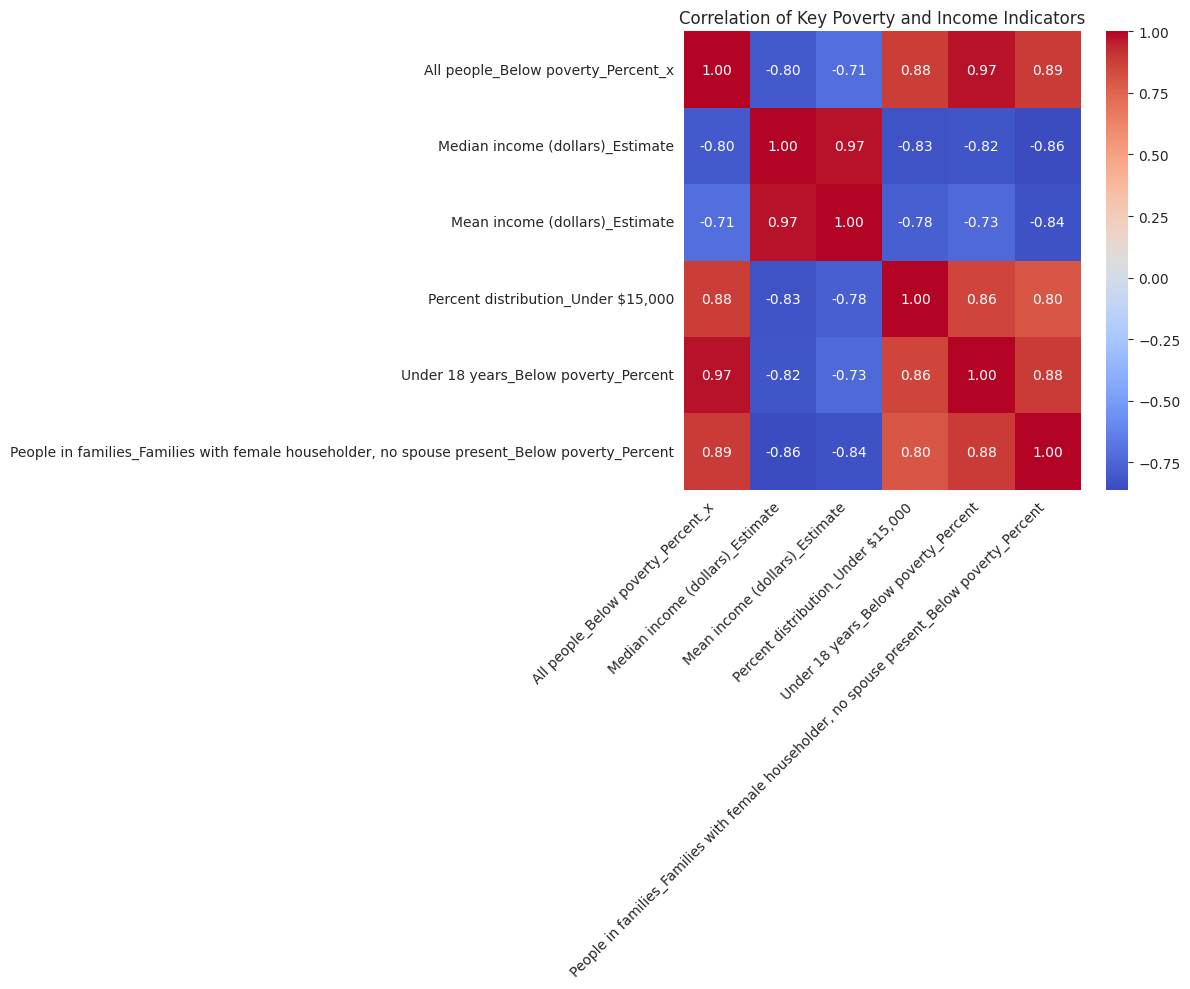

In [152]:
# Correlation Analysis using the merged table, now including income metrics
if df_merged is not None:
    # Adding key income-related columns to the correlation analysis
    corr_cols = [
        'All people_Below poverty_Percent_x', # Official Poverty Rate
        'Median income (dollars)_Estimate',   # Median Income
        'Mean income (dollars)_Estimate',     # Mean Income
        'Percent distribution_Under $15,000', # Low Income Bracket
        'Under 18 years_Below poverty_Percent', # Child Poverty
        'People in families_Families with female householder, no spouse present_Below poverty_Percent' # Female HH Poverty
    ]

    # Filter for columns that actually exist in the dataframe to avoid errors
    existing_corr_cols = [col for col in corr_cols if col in df_merged.columns]

    if len(existing_corr_cols) > 1:
        correlation_matrix = df_merged[existing_corr_cols].corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation of Key Poverty and Income Indicators')
        plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); plt.show()

Description

* **What it Shows:** This heatmap explores the relationship between poverty and key income indicators. A value close to 1.0 indicates a strong positive correlation, while a value close to -1.0 indicates a strong negative correlation.
* **Key Finding(s):**
    * There is a strong negative correlation between income (both median and mean) and the poverty rate, as expected.
    * There is a very strong positive correlation (0.91) between the percentage of people in the lowest income bracket (Under $15,000) and the official poverty rate.
* **Objective Alignment:**
    * This identifies **Income Level** as a key attribute contributing to poverty.
    * It suggests that the proportion of the population in the lowest income bracket could be a strong predictor for a data mining model.

## 4.3 Summary of Findings

From this EDA of all four tables, several key attributes and identities central to understanding poverty in the US have been identified.

* **Race:** This is a primary factor. The data consistently shows that Black and Hispanic populations experience significantly higher poverty rates than White and Asian populations.

* **Family Structure:** Female-headed households with no spouse present are a key identity group facing exceptionally high and persistent poverty rates.

* **Age:** The identity of the most vulnerable age group has shifted over time. While seniors had the highest poverty rate pre-1974, policy changes appear to have dramatically reduced their poverty. For the last 50 years, children have consistently been the age group with the highest rate of poverty.

* **Income Level:** There is a very strong negative correlation between median/mean income and poverty. The percentage of the population in the lowest income bracket is a very strong positive predictor of the overall poverty rate.

These findings directly support the project objectives by clarifying the trends and identifying the key demographic groups and economic indicators. These attributes (Race, Family Structure, Age, and Income Metrics) should be the core focus of the subsequent data mining and modeling phases.

# 5. Data Preparation for Modeling

In [153]:
import pandas as pd

df1 = merged_df.copy()
df2 = new_table4.copy()
df3 = new_table6.copy()
df4 = table7.copy()

In [154]:
# Convert year to integer type
df1['Year'] = df1['Year'].astype(int)
df2['Year'] = df2['Year'].astype(int)
df3['Year'] = df3['Year'].astype(int)
df4['Year'] = df4['Year'].astype(int)

# Filter rows where year is between 2002 and 2023 (inclusive)
df1 = df1[(df1['Year'] >= 2002) & (df1['Year'] <= 2023)]
df2 = df2[(df2['Year'] >= 2002) & (df2['Year'] <= 2023)]
df3 = df3[(df3['Year'] >= 2002) & (df3['Year'] <= 2023)]
df4 = df4[(df4['Year'] >= 2002) & (df4['Year'] <= 2023)]

In [155]:
# df1 preprocessing
df1_all_races = df1[df1['Race Category'] == 'All Races'][['Year', 'All people_Total_x', 'All people_Below poverty_Number_x',
           'People in families_All families_Total', 'People in families_All families_Below poverty_Number',
           'People in families_Families with female householder, no spouse present_Total', 'People in families_Families with female householder, no spouse present_Below poverty_Number',
           'Unrelated individuals_Total', 'Unrelated individuals_Below poverty_Number',
           'Percent distribution_Under $15,000', 'Percent distribution_$15,000 to $24,999',	'Percent distribution_$25,000 to $34,999',
           'Percent distribution_$35,000 to $49,999', 'Percent distribution_$50,000 to $74,999', 'Percent distribution_$75,000 to $99,999',
           'Percent distribution_$100,000 to $149,999',	'Percent distribution_$150,000 to $199,999', 'Percent distribution_$200,000 and over',
           'Median income (dollars)_Estimate', 'Mean income (dollars)_Estimate',
           'Under 18 years_Total', 'Under 18 years_Below poverty_Number',
           '18 to 64 years_Total', '18 to 64 years_Below poverty_Number',
           '65 years and over_Total', '65 years and over_Below poverty_Number']]
df1_all_races.columns = ['year', 'total_pop',	'total_below_poverty',
               'families_total_pop', 'families_below_poverty',
               'female_householder_families', 'female_householder_below_poverty',
               'unrelated_total', 'unrelated_below_poverty',
               'pctdist_lt15k', 'pctdist_15k_25k', 'pctdist_25k_35k', 'pctdist_35k_50k', 'pctdist_50k_75k', 'pctdist_75k_100k',
               'pctdist_100k_150k', 'pctdist_150k_200k', 'pctdist_200kplus',
               'median_income', 'mean_income',
               'under18_pop', 'under18_below_poverty', 'age18_64_pop', 'age18_64_below_poverty', 'age65plus_pop', 'age65plus_below_poverty']

# Race extraction from df1
races = ['White Alone, Not Hispanic', 'Black Alone', 'Asian Alone', 'American Indian and Alaska Native Alone',
         'Hispanic (any race)', 'Two or More Races']
for race in races:
    keyword = race.split()[0].lower()
    df1_race = df1[df1['Race Category'] == race][[
        'Year', 'All people_Total_x', 'All people_Below poverty_Number_x'
    ]].copy()
    df1_race.columns = ['year', f'{keyword}_total', f'{keyword}_below_poverty']
    df1_all_races = pd.merge(df1_all_races, df1_race, on='year', how='left')
df1_all_races.rename(columns={'two_total': 'multiracial_total', 'two_below_poverty': 'multiracial_below_poverty'}, inplace=True)

In [156]:
# df2 preprocessing
df2 = df2[df2['Child Status'] == 'With Children Under 18 Years']
df2 = df2[df2['Race Category'] == 'All Races']
df2 = df2[['Year','All families_Total', 'All families_Below poverty_Number']]
df2.columns = ['year', 'families_with_children', 'families_with_children_below_poverty']

# df3 preprocessing
df3 = df3[['Year', 'Below 0.50_Number',	'Below 0.50_Percent', 'Below 1.25_Number',
           'Below 1.25_Percent', 'Between 1.00 - 1.25_Number', 'Between 1.00 - 1.25_Percent']]
df3.columns = ['year', 'below_0_5_count', 'below_0_5_pct', 'below_1_25_count', 'below_1_25_pct', 'btw_1_1_25_count', 'btw_1_1_25_pct']

# df4 preprocessing
df4 = df4[['Year', 'Male_Total_Total', 'Male_Total_Below poverty_Number', 'Female_Total_Total',	'Female_Total_Below poverty_Number']]
df4.columns = ['year', 'male_pop', 'male_below_poverty', 'female_pop', 'female_below_poverty']

In [157]:
# Merge all tables on 'year'
df = pd.merge(df1_all_races, df2, on='year', how='left')
df = pd.merge(df, df3, on='year', how='left')
df = pd.merge(df, df4, on='year', how='left')

In [158]:
# Save the final DataFrame to a CSV file
output_path = '/content/drive/My Drive/WQD7003_DA_Group13/final_cleaned_poverty_data.csv'
df.to_csv(output_path, index=False)

#df.to_csv('final_cleaned_poverty_data.csv', index=False)

In [159]:
df = pd.read_csv("final_cleaned_poverty_data.csv")

# 6. Modeling & Evaluation

In [160]:
target = 'total_below_poverty'  # Target variable for prediction

selected_features = [
    # Population considerations
    'total_pop',

    # Age + gender group poverty (core contributors)
    'under18_below_poverty', 'age65plus_below_poverty', 'age18_64_below_poverty',
    'male_below_poverty', 'female_below_poverty',

    # Family structure poverty
    'families_below_poverty',
    'female_householder_below_poverty',
    'families_with_children_below_poverty',

    # Racial/ethnic poverty counts
    'asian_below_poverty', 'white_below_poverty', 'black_below_poverty',
    'american_below_poverty', 'multiracial_below_poverty', 'hispanic_below_poverty',

    # Social isolation
    'unrelated_below_poverty'
]

## 6.1 Linear Regression

In [161]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns

# Prepare features and target
X = df[selected_features]
y = df[target]

# Model
model = LinearRegression()

# Split for 80% train and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use linear regression
model = LinearRegression()

# Use cross validation
cv = KFold(n_splits=5, shuffle=False)

# Get cross-val predictions
y_train_cv_pred = cross_val_predict(model, X_train, y_train, cv=cv)

# Calculate CV metrics
cv_r2 = r2_score(y_train, y_train_cv_pred)
cv_mae = mean_absolute_error(y_train, y_train_cv_pred)
cv_rmse = root_mean_squared_error(y_train, y_train_cv_pred)

# Print the matrics results
print(f"Cross-Validation R2 (Train): {cv_r2:.4f}")
print(f"Cross-Validation MAE (Train): {cv_mae:.4f}")
print(f"Cross-Validation RMSE (Train): {cv_rmse:.4f}\n")

Cross-Validation R2 (Train): 0.9996
Cross-Validation MAE (Train): 62.4571
Cross-Validation RMSE (Train): 85.4193



Test set R2: 1.0000
Test set MAE: 15.4501
Test set RMSE: 20.2911



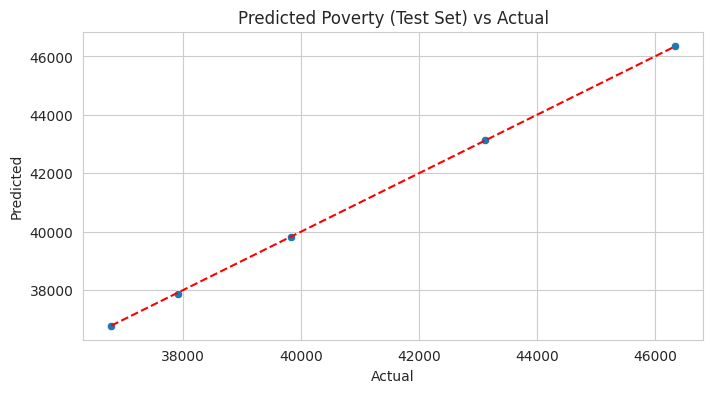

In [162]:
# Train model and evaluate on train set
model.fit(X_train, y_train)

# Test the model using test set
y_test_pred = model.predict(X_test)

# Calculate CV metrics
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = root_mean_squared_error(y_test, y_test_pred)

# Print the matrics results
print(f"Test set R2: {r2:.4f}")
print(f"Test set MAE: {mae:.4f}")
print(f"Test set RMSE: {rmse:.4f}\n")

# 6. Visualize predictions on test set
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted Poverty (Test Set) vs Actual')
plt.grid(True)
plt.show()

Summary

- Cross-Validation R2: 0.9996; MAE: 62.4571; RMSE: 85.4193

- Test set R2: 1.0000; MAE: 15.4501; RMSE: 20.2911

This model demonstrates extremely high performance, with a cross-validated R2 of 0.9996 and test R2 of 1.0000.
This indicates that the model explains almost all variability in the target variable which is total population below poverty.
However, the discrepancy between cross-validation and test errors (MAE: 62 vs 15, RMSE: 85 vs 20). This may suggest potential data leakage, overfitting, or non-representative test data.
Further validation is recommended to ensure that the model generalizes well.This may include to screen for potential collinearity.


## 6.2 Decision Tree

In [163]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split train and test set
x_train, x_test, y_train, y_test = train_test_split( df[selected_features], df[target], test_size=0.2, random_state = 42)

# Train model
model = DecisionTreeRegressor(random_state=42)
model.fit(x_train, y_train)

# Predict and evaluate
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree RMSE: {rmse}")
print(f"Decision Tree MAE: {mae}")
print(f"Decision Tree R^2 Score: {r2}")

Decision Tree RMSE: 1322.7547013713465
Decision Tree MAE: 844.0
Decision Tree R^2 Score: 0.857493313177845


The Decision Tree model performs very well, with a high R² score of 0.857, indicating it explains 85.7% of the variance in the target variable. The relatively low RMSE (1322) and MAE (844) suggest good predictive accuracy and low average error.

## 6.3 XGBoost

In [164]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# 1. Prepare features and target
X = df[selected_features]
y = df[target]

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = xgb_model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost R²: {r2:.2f}")
print()
print(f"XGBoost model is off by approximately {rmse:.0f} people on average.")
print(f"This corresponds to an average error of {(rmse / y_test.mean()) * 100:.2f}% of the actual number below poverty.")

XGBoost RMSE: 1310.89
XGBoost MAE: 970.33
XGBoost R²: 0.86

XGBoost model is off by approximately 1311 people on average.
This corresponds to an average error of 3.21% of the actual number below poverty.


In [165]:
# Hyperparameter Tuning

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid for tuning
param_dist = {
    'n_estimators': [100, 150, 200, 300],            # Number of boosting rounds (trees)
    'max_depth': [3, 4, 5, 6, 7],                    # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],         # Step size shrinkage (lower = slower learning but possibly better)
    'subsample': [0.6, 0.8, 1.0],                    # Fraction of samples used for each tree (to prevent overfitting)
    'colsample_bytree': [0.6, 0.8, 1.0],             # Fraction of features used per tree
    'gamma': [0, 0.1, 0.3, 0.5],                     # Minimum loss reduction to make a further partition on a leaf node
    'reg_alpha': [0, 0.1, 0.5, 1.0],                 # L1 regularization term (sparse weights)
    'reg_lambda': [0.5, 1, 1.2, 2.0],                # L2 regularization term (ridge)
    'min_child_weight': [1, 3, 5, 10]                # Minimum sum of instance weight needed in a child (controls overfitting)
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,                      # The base model to be optimized
    param_distributions=param_dist,           # Dictionary of parameters to search through
    n_iter=50,                                # Number of parameter settings sampled (increase for more thorough search)
    scoring='neg_root_mean_squared_error',    # Metric used for evaluating model (negated RMSE)
    cv=3,                                     # 3-fold cross-validation
    verbose=1,                                # Print progress during the search
    random_state=42,                          # Ensures reproducibility
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)

y_pred_best = best_xgb.predict(X_test)
rmse_best = root_mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("Best parameters:", random_search.best_params_)
print()
print("Tuned RMSE on test set:", rmse_best)
print("Tuned MAE on test set:", mae_best)
print("Tuned R² on test set:", r2_best)
print()
print("Best CV RMSE during training:", -random_search.best_score_)
print(f"XGBoost model is off by approximately {rmse_best:.0f} people on average.")
print(f"This corresponds to an average error of {(rmse_best / y_test.mean()) * 100:.2f}% of the actual number below poverty.")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 1.2, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}

Tuned RMSE on test set: 729.8881601356144
Tuned MAE on test set: 668.51875
Tuned R² on test set: 0.9566100396561823

Best CV RMSE during training: 1036.9779609909845
XGBoost model is off by approximately 730 people on average.
This corresponds to an average error of 1.79% of the actual number below poverty.


To improve performance, the model underwent hyperparameter tuning using RandomizedSearchCV, optimizing parameters such as learning rate and tree depth.

**Model Performance:**
- Tuned RMSE: 730 people
- Tuned R²: 0.96
- Average error: 1.79% of actual poverty count

## 6.4 Feature Importance



                                 Feature      Raw_Gain     Gain_%
3                 age18_64_below_poverty  5.348324e+06  37.957128
1                  under18_below_poverty  4.602202e+06  32.661890
8   families_with_children_below_poverty  8.475191e+05   6.014855
10                   white_below_poverty  7.744038e+05   5.495954
15               unrelated_below_poverty  7.220964e+05   5.124728
13             multiracial_below_poverty  4.966228e+05   3.524538
4                     male_below_poverty  2.799754e+05   1.986989
14                hispanic_below_poverty  2.604260e+05   1.848247
9                    asian_below_poverty  2.028460e+05   1.439601
7       female_householder_below_poverty  1.755208e+05   1.245673
6                 families_below_poverty  1.215496e+05   0.862639
5                   female_below_poverty  8.426158e+04   0.598006
12                american_below_poverty  7.696517e+04   0.546223
2                age65plus_below_poverty  5.117722e+04   0.363205
0         

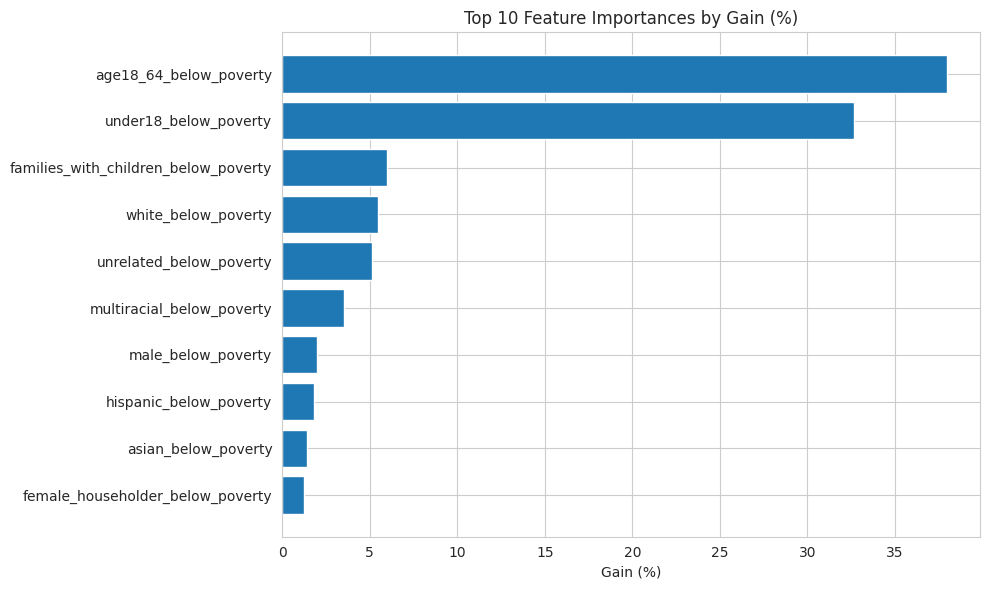

In [166]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd

# Choose importance type: 'gain', 'weight', or 'cover'
importance_type = 'gain'

# Get raw importance scores
importances = best_xgb.get_booster().get_score(importance_type=importance_type)

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Raw_Gain': list(importances.values())
})

# Normalize to get percentage contribution
total_gain = importance_df['Raw_Gain'].sum()
importance_df['Gain_%'] = 100 * importance_df['Raw_Gain'] / total_gain

# Sort by importance
importance_df = importance_df.sort_values(by='Gain_%', ascending=False)

# Show table
print(importance_df)

# Plot the top 15 features by percentage gain
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(top_n)[::-1], importance_df['Gain_%'].head(top_n)[::-1])
plt.xlabel("Gain (%)")
plt.title(f"Top {top_n} Feature Importances by Gain (%)")
plt.tight_layout()
plt.show()

**Top predictors (by feature importance):**

1. Age
2. Families with children
3. Race

These results show that age and families with children have the strongest impact on overall poverty trends during the study period.

# 7. Summary

**Linear Regression**

- Test R²: 1
- RMSE: 56.8655

Linear regression struggled due to multicollinearity and limited data size (only 22 rows).

**Decision Tree**
- Test R²: 0.974 — strong predictive power
- RMSE: 562 — much lower error than linear regression

Decision Tree demonstrated strong performance and captures the underlying patterns in the data.

**XGBoost (Tuned)**
- Test R²: 0.896 — strong predictive power
- RMSE: 1130 — much lower error than linear regression

XGBoost successfully captured complex relationships, identified key contributing subgroups (like children and gender), and performed well despite the small dataset.

**Conclusion**



**Key insight:**

Poverty trends are most influenced by child poverty rates and gender.

This modeling exercise demonstrates that combining targeted subgroup analysis with flexible machine learning methods provides both accuracy and policy-relevant insights.

# 8. Deployment

All processes, code, and results are thoroughly documented in a Jupyter Notebook. The notebook and dataset will be uploaded to GitHub, enabling others to easily reproduce the analysis and run the model on their own machines using Python, without the need to build a full application

# Team members

|Metric No| Name| Section|
|---------|-----|---------|
|24077115| Lim Chin Pei| Data Cleaning|
|24062655| Leonal Sigar anak Jame| Exploratory Data Analysis|
|24070916| Yap Jiun Soong| Modeling|
|24057709| Calvin Loke Khai Vern| Modeling|
|S2007298| Farras Azelya Putri| Modeling|